In [65]:
import torch
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
import winsound
from project.utils import compute_statistics

In [66]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/kess_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_06_2024_100542'

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [68]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt

class VALDODataset(Dataset):
    def __init__(self, cases, masks, target, transform):
        self.cases = cases
        self.masks = masks
        self.target = target
        self.transform = transform

        assert len(self.cases) == len(
            self.masks), "Cases and masks must have the same length"

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        try:
            case = self.cases[idx]
            mask = self.masks[idx]
            target = self.target[idx]
        
            slices, masks = self.transform(mri_image_path=case, segmentation_mask_path=mask)
            
            # print(f'slices {slices}')
            # print(f'masks {masks}')
            if slices is None or masks is None:
                raise ValueError(f"Transform returned None for {case} and {mask}")
            
            return slices, masks, target, case
        
        except Exception as e:
            print(f'Error loading image: {e}')
            return None, None, None, None

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x + w, y + h])
        return boxes

    def count_cmb_per_image(self, segmented_images):
        cmb_counts = []
        for img_path in segmented_images:
            img = nib.load(img_path)
            data = img.get_fdata()
            slice_cmb_counts = [self.extract_bounding_boxes(
                (data[:, :, i] > 0).astype(np.uint8)) for i in range(data.shape[2])]
            total_cmb_count = sum(len(contours)
                                  for contours in slice_cmb_counts)
            cmb_counts.append(total_cmb_count)
        return cmb_counts

    def locate_case_by_mri(self, case_name): # Find a specific case using name search
        # Enumerate to all masks name
        for idx, case in enumerate(self.cases):
            if case_name in case:
                # Return case details
                return self.__getitem__(idx)
        # If no match found
        return None

    def locate_case_by_name(self, case_name): # Find a specific case using name search
        # Enumerate to all masks name
        for idx, case in enumerate(self.masks):
            if case_name in case:
                # Return case details
                return self.__getitem__(idx)
        # If no match found
        return None
    
    def get_cropped_locations(self, img, x_min, y_min, x_max, y_max):
        """
        Display the specified location across all slices of the MRI.

        :param idx: Index of the MRI scan in the dataset.
        :param x_min: Minimum x coordinate of the location.
        :param y_min: Minimum y coordinate of the location.
        :param x_max: Maximum x coordinate of the location.
        :param y_max: Maximum y coordinate of the location.
        """
        target_size = (16, 16)
        try:
            # img_path = self.img_paths[idx]

            # # Load 3D image
            # img = nib.load(img_path).get_fdata()
            # # img = (img / np.max(img) * 255).astype(np.uint8)
            # img, targets, img_path, cmb_count = self.__getitem__(idx=idx)
            cropped_slices = []

            # Iterate through each slice and crop to the specified region
            # print(img.shape)
            if img.dim() == 5:
        # If 5D, assume shape is [num_slices, channels, height, width]
                for i in range(img.__len__()):
                    img_slice = img[i]
                    cropped_slice = img_slice[0, 0, y_min:y_max, x_min:x_max]
                    cropped_slice = torch.Tensor(cropped_slice).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
                    resized_slice = F.interpolate(cropped_slice, size=target_size, mode='bilinear', align_corners=False)
                    cropped_slices.append(resized_slice.squeeze())  # Remove unnecessary dimensions

                # current_width = combined_slices.shape[1]
                # pad_width = max_width - current_width
                # padded_image = np.pad(combined_slices, ((0, 0), (0, pad_width)), mode='constant')

                # plt.imshow(padded_image, cmap='gray')
                # plt.title(f'Slice {i}')
                # plt.show()
                return torch.stack(cropped_slices, dim=0).unsqueeze(0).unsqueeze(0)

            elif img.dim() == 4:
                # If 4D, assume shape is [num_slices, height, width]
                for i in range(img.shape[0]):
                    img_slice = img[i, 0]  # Extract the 2D slice (assuming single channel)
                    cropped_slice = img_slice[y_min:y_max, x_min:x_max]
                    cropped_slice = torch.Tensor(cropped_slice).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
                    resized_slice = F.interpolate(cropped_slice, size=target_size, mode='bilinear', align_corners=False)
                    cropped_slices.append(resized_slice.squeeze())  # Remove unnecessary dimensions

                # # for i in range(img.__len__()):
                # #     returned.append(cropped_slices)
                # combined_slices = np.hstack(cropped_slices)
                # current_width = combined_slices.shape[1]
                # pad_width = max_width - current_width
                # padded_image = np.pad(combined_slices, ((0, 0), (0, pad_width)), mode='constant')

                # plt.imshow(padded_image, cmap='gray')
                # plt.title(f'Slice {i}')
                # plt.show()
                return torch.stack(cropped_slices, dim=0).unsqueeze(0)

            else:
                raise ValueError("Unsupported tensor dimension. Expected 3D or 4D tensor.")


        except Exception as e:
            print(f"Error processing: {e}")
            raise



### Transformations


In [69]:
import torch
import torch.nn as nn
import math
from torchvision.models import resnet18, ResNet18_Weights

class RPNPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class PretrainedEmbedder(nn.Module):
    def __init__(self, model, weights):
        super().__init__()
        pretrained_model = model(weights=weights)
        no_classifier = list(pretrained_model.children())[:-1]
        self.embedder = nn.Sequential(*(no_classifier))

    def forward(self, x):
        return self.embedder(x)

class SliceEmbedding(nn.Module):
    def __init__(self, image_size, output_dim, in_channels=1, out_channels=1, kernel_size=2, stride=2):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=kernel_size , stride=stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, stride=stride),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=kernel_size, stride=stride),
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            
            # nn.Conv2d(in_channels=24, out_channels=24, kernel_size=kernel_size, stride=stride),
            # nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=kernel_size, stride=stride),
            nn.Dropout(0.1),
            nn.Flatten(2)
        )

        # Calculate shape after convolutions
        with torch.inference_mode():
            x = torch.zeros(1, in_channels, image_size, image_size)
            output = self.convs(x)
            final_d = output.numel()

        print(final_d)

        self.mlp = nn.Sequential(
            nn.Linear(final_d, output_dim)
        )


    def forward(self, x):
        out = self.convs(x)
        return self.mlp(out)

class RPN(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 image_size,
                 nh=5,
                 n_layers=1,
                 dim_ff=2500,
                 pretrained=False,
                 embed_model=resnet18,
                 embed_weights=(ResNet18_Weights.IMAGENET1K_V1),
                 *a,
                 **k
                 ):
        super().__init__()

        if pretrained is True:
            self.embedder = PretrainedEmbedder(embed_model, embed_weights)
        else:
            self.embedder = SliceEmbedding(image_size=image_size, output_dim=input_dim)

        # input_dim=512
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nh, dim_feedforward=dim_ff)
        self.trans_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.posenc = RPNPositionalEncoding(d_model=input_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x, i):

        slices = self.embedder(x)
        slices = slices.view(slices.shape[0], 1, -1)
        slices = self.posenc(slices)
        out = self.trans_encoder(slices)
        out = self.trans_encoder(slices[i])
        out = self.fc(out)

        return out


In [70]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import torch
import nibabel as nib
import cv2

def get_transform(height, width, p, rpn_mode):
    if rpn_mode is False:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            is_check_shapes=False
        )
    else:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            p=p,
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0,
                min_visibility=0,
                label_fields=['labels']
            )
        )

class NiftiToTensorTransform:
    def __init__(self, target_shape=(512,512), in_channels=1, rpn_mode=False, normalization=None):
        self.target_shape = target_shape
        self.in_channels = in_channels
        self.transform = get_transform(
            height=target_shape[0],
            width=target_shape[1],
            p=1.0,
            rpn_mode=rpn_mode
        )
        self.rpn_mode = rpn_mode
        self.normalization = normalization
        
    def convert_to_binary_mask(self, segmentation_mask):
        binary_mask = (segmentation_mask > 0).astype(np.uint8)
        return binary_mask

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x-5, y-5, x + w+5, y + h+5])
        return boxes
    
    def normalize_slice(self, slice):
        min, max = self.normalization
        slice = (slice - min) / (max - min)
        
        return slice

    def __call__(self, mri_image_path, segmentation_mask_path):
        try:
            mri_image = nib.load(mri_image_path).get_fdata()
            segmentation_mask = nib.load(segmentation_mask_path).get_fdata()
            
            if self.normalization is not None:
                mri_image = np.stack([self.normalize_slice(mri_image[:, :, i]) for i in range(mri_image.shape[2])], axis=-1)
                
            segmentation_mask = self.convert_to_binary_mask(segmentation_mask) # USE THIS
            
            image_slices = []
            mask_slices = []
            
            if self.rpn_mode == False:
                for i in range(mri_image.shape[2]):
                    augmented = self.transform(
                        image=mri_image[:, :, i], 
                        mask=segmentation_mask[:, :, i]
                    )
                
                    image_slices.append(augmented['image'].unsqueeze(0)) 
                    mask_slices.append(augmented['mask'].unsqueeze(0))   
    
                image = torch.stack(image_slices) 
                mask = torch.stack(mask_slices)  
            
                if image.shape[1] != 1 or mask.shape[1] != 1:
                    raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")

                return image, mask

            else: # RPN transformation
                for i in range(mri_image.shape[2]):
                    boxes = self.extract_bounding_boxes(segmentation_mask[:, :, i])
                    if boxes:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=boxes,
                            labels=[1]*len(boxes)
                        )
                        img_slice = augmented['image']
                        boxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
                        labels = augmented['labels']
                    else:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=[],
                            labels=[]
                        )
                        img_slice = augmented['image']
                        boxes = torch.zeros((1, 4), dtype=torch.float32)
                        labels = augmented['labels']
                    
                    image_slices.append(img_slice.unsqueeze(0))
                    boxes = torch.clamp(boxes, min=0, max=self.target_shape[0])
                    mask_slices.append(boxes.unsqueeze(0))
            
                # image = torch.stack(image_slices) 
                # mask = torch.stack(mask_slices)  
                image = [image_slices]
                mask = [mask_slices]
                
                return image, mask
            
                # if image.shape[1] != 1 or mask.shape[1] != 1:
                #     raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")
        
        except Exception as e:
            print(f"Error in __call__ with {mri_image} and {segmentation_mask}: {e}")
            return None, None


### Config for fitter


In [71]:
from project.model import RPN
import torch.nn as nn

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 4,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.00001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load dataset


In [72]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [73]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000


### `DataLoader` Generator


In [74]:
def collatev2(batch):
    images = []
    masks = []
    targets = []
    cases = []

    for item in batch:
        image, mask, target, case = item
        
        images.append(image)
        masks.append(mask)
        targets.append(target)
        cases.append(case)

    return images, masks, targets, cases

In [75]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

### Fitter


In [76]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        self.model.to(self.device)
        counter = 0
        total_loss = 0
        loss_history = []
        
        for batch in train_loader:
            images, masks, targets, cases = batch
            
            for slices, masks, target, case in zip(images, masks, targets, cases):
                x = torch.stack(slices[0]).squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                print(f'target {target}')
                processed_masks = masks[0][target].float().to(self.device)/300
                print(f'processed_masks {processed_masks}')
                
                self.optimizer.zero_grad()
                outputs = self.model(x, target)
                
                batch_loss = self.calculate_loss(outputs, processed_masks)
                batch_loss.backward()  
                self.optimizer.step()
                counter += 1
                
                self.log(f'Batch:\t{counter}/{len(train_loader)}')
                self.log(f'Batch samples:\t{len(batch)}')
                total_loss += batch_loss.item()
                self.logger.info(f"Current Loss: {batch_loss.item()}")
            
                loss_history.append(batch_loss.detach().cpu().numpy())

        return loss_history

    def validation(self, val_loader):
        self.model.eval()
        total_loss = 0
        loss_history = []
        
        with torch.inference_mode():  
            for batch in val_loader:
                images, masks, targets, cases = batch
                
                for slices, masks, target, case in zip(images, masks, targets, cases):
                    x = torch.stack(slices[0]).squeeze(1).repeat(1, 3, 1, 1).float().to(device)
                    processed_masks = masks[0][target].float().to(self.device)/300
                    
                    outputs = self.model(x, target)
                    loss = self.calculate_loss(outputs, processed_masks)
                    total_loss += loss.item()
            
                loss_history.append(loss.detach().cpu().numpy())

        return loss_history

    def calculate_loss(self, outputs, masks):
        total_loss = 0
        for output, mask in zip(outputs, masks):
            print(f'\t----rpn loss output {output}')
            print(f'\t----rpn loss mask {mask}')
            total_loss += torch.nn.functional.mse_loss(output, mask)
            print(f'\t---- total loss {total_loss}')
            
        return total_loss
            

In [77]:
fitter = RPNFitter(config, logger=logger)

### Training


In [78]:
tl, vl = make_loaders(
    data=data,
    cohort=1,
    batch_size=5
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [79]:
thist, vhist = fitter.fit(tl, vl)

INFO:kess:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 16
processed_masks tensor([[[0.4824, 0.5840, 0.5098, 0.6113],
         [0.5117, 0.5781, 0.5391, 0.6074],
         [0.5000, 0.5605, 0.5371, 0.5996],
         [0.5254, 0.5547, 0.5586, 0.6016],
         [0.5332, 0.5449, 0.5625, 0.5742],
         [0.5156, 0.4121, 0.5488, 0.4531],
         [0.5293, 0.4082, 0.5566, 0.4355],
         [0.4980, 0.4043, 0.5254, 0.4414],
         [0.5078, 0.3926, 0.5410, 0.4238],
         [0.4785, 0.3867, 0.5098, 0.4160]]], device='cuda:0')


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([10, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	1/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3486, 0.3948, 0.7488, 0.4465], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.5840, 0.5098, 0.6113],
        [0.5117, 0.5781, 0.5391, 0.6074],
        [0.5000, 0.5605, 0.5371, 0.5996],
        [0.5254, 0.5547, 0.5586, 0.6016],
        [0.5332, 0.5449, 0.5625, 0.5742],
        [0.5156, 0.4121, 0.5488, 0.4531],
        [0.5293, 0.4082, 0.5566, 0.4355],
        [0.4980, 0.4043, 0.5254, 0.4414],
        [0.5078, 0.3926, 0.5410, 0.4238],
        [0.4785, 0.3867, 0.5098, 0.4160]], device='cuda:0')
	---- total loss 0.02415299415588379


INFO:kess:Current Loss: 0.02415299415588379


target 15
processed_masks tensor([[[0.2930, 0.3574, 0.3223, 0.3848]]], device='cuda:0')
	----rpn loss output tensor([0.4178, 0.5374, 0.6082, 0.4193], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2930, 0.3574, 0.3223, 0.3848]], device='cuda:0')
	---- total loss 0.03273417055606842


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	2/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.03273417055606842


target 16
processed_masks tensor([[[0.5117, 0.5781, 0.5391, 0.6074],
         [0.5059, 0.5645, 0.5332, 0.5938],
         [0.5195, 0.5605, 0.5488, 0.5879],
         [0.5137, 0.4199, 0.5430, 0.4512],
         [0.4961, 0.4121, 0.5215, 0.4395]]], device='cuda:0')
	----rpn loss output tensor([0.4858, 0.4632, 0.5193, 0.4244], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5117, 0.5781, 0.5391, 0.6074],
        [0.5059, 0.5645, 0.5332, 0.5938],
        [0.5195, 0.5605, 0.5488, 0.5879],
        [0.5137, 0.4199, 0.5430, 0.4512],
        [0.4961, 0.4121, 0.5215, 0.4395]], device='cuda:0')
	---- total loss 0.0066201770678162575


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([5, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	3/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0066201770678162575


target 20
processed_masks tensor([[[0.1719, 0.5977, 0.1992, 0.6250],
         [0.6992, 0.4375, 0.7246, 0.4648],
         [0.2500, 0.3047, 0.2773, 0.3320]]], device='cuda:0')


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([3, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	4/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5143, 0.4071, 0.4478, 0.3652], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1719, 0.5977, 0.1992, 0.6250],
        [0.6992, 0.4375, 0.7246, 0.4648],
        [0.2500, 0.3047, 0.2773, 0.3320]], device='cuda:0')
	---- total loss 0.042919646948575974


INFO:kess:Current Loss: 0.042919646948575974


target 26
processed_masks tensor([[[0.2207, 0.4531, 0.2480, 0.4785],
         [0.2969, 0.4512, 0.3223, 0.4766],
         [0.2168, 0.4395, 0.2441, 0.4668],
         [0.2051, 0.4316, 0.2324, 0.4609],
         [0.1641, 0.4199, 0.1953, 0.4492],
         [0.2090, 0.3828, 0.2344, 0.4102],
         [0.2031, 0.3652, 0.2324, 0.3945],
         [0.2207, 0.3633, 0.2480, 0.3887],
         [0.2246, 0.3516, 0.2539, 0.3789],
         [0.2402, 0.3398, 0.2656, 0.3672],
         [0.2305, 0.3320, 0.2598, 0.3594],
         [0.2441, 0.3164, 0.2734, 0.3457],
         [0.2656, 0.3027, 0.2949, 0.3301]]], device='cuda:0')


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([13, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	5/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.7124, 0.5029, 0.4819, 0.4736], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2207, 0.4531, 0.2480, 0.4785],
        [0.2969, 0.4512, 0.3223, 0.4766],
        [0.2168, 0.4395, 0.2441, 0.4668],
        [0.2051, 0.4316, 0.2324, 0.4609],
        [0.1641, 0.4199, 0.1953, 0.4492],
        [0.2090, 0.3828, 0.2344, 0.4102],
        [0.2031, 0.3652, 0.2324, 0.3945],
        [0.2207, 0.3633, 0.2480, 0.3887],
        [0.2246, 0.3516, 0.2539, 0.3789],
        [0.2402, 0.3398, 0.2656, 0.3672],
        [0.2305, 0.3320, 0.2598, 0.3594],
        [0.2441, 0.3164, 0.2734, 0.3457],
        [0.2656, 0.3027, 0.2949, 0.3301]], device='cuda:0')
	---- total loss 0.07858803123235703


INFO:kess:Current Loss: 0.07858803123235703
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 5
processed_masks tensor([[[0.2480, 0.5332, 0.2793, 0.5625]]], device='cuda:0')
	----rpn loss output tensor([0.4471, 0.3194, 0.7263, 0.5916], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2480, 0.5332, 0.2793, 0.5625]], device='cuda:0')
	---- total loss 0.07150627672672272


INFO:kess:Batch:	6/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.07150627672672272


target 17
processed_masks tensor([[[0.4863, 0.5566, 0.5508, 0.6094],
         [0.5117, 0.4219, 0.5391, 0.4512],
         [0.5234, 0.4141, 0.5527, 0.4434],
         [0.5039, 0.4102, 0.5293, 0.4375],
         [0.5117, 0.3984, 0.5488, 0.4336],
         [0.4785, 0.3945, 0.5176, 0.4297]]], device='cuda:0')
	----rpn loss output tensor([0.3872, 0.2899, 0.3680, 0.6036], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4863, 0.5566, 0.5508, 0.6094],
        [0.5117, 0.4219, 0.5391, 0.4512],
        [0.5234, 0.4141, 0.5527, 0.4434],
        [0.5039, 0.4102, 0.5293, 0.4375],
        [0.5117, 0.3984, 0.5488, 0.4336],
        [0.4785, 0.3945, 0.5176, 0.4297]], device='cuda:0')
	---- total loss 0.022342180833220482


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([6, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	7/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.022342180833220482


target 31
processed_masks tensor([[[0.3145, 0.4414, 0.3418, 0.4688],
         [0.2617, 0.4336, 0.2871, 0.4609],
         [0.2559, 0.4238, 0.2812, 0.4492],
         [0.3242, 0.4219, 0.3535, 0.4531],
         [0.2480, 0.4160, 0.2734, 0.4414]]], device='cuda:0')
	----rpn loss output tensor([0.4581, 0.2101, 0.3785, 0.6008], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3145, 0.4414, 0.3418, 0.4688],
        [0.2617, 0.4336, 0.2871, 0.4609],
        [0.2559, 0.4238, 0.2812, 0.4492],
        [0.3242, 0.4219, 0.3535, 0.4531],
        [0.2480, 0.4160, 0.2734, 0.4414]], device='cuda:0')
	---- total loss 0.026824554428458214


INFO:kess:Batch:	8/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.026824554428458214


target 17
processed_masks tensor([[[0.4512, 0.4668, 0.4883, 0.5039],
         [0.4043, 0.4375, 0.4355, 0.4668]]], device='cuda:0')
	----rpn loss output tensor([0.5983, 0.4429, 0.3668, 0.4257], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4512, 0.4668, 0.4883, 0.5039],
        [0.4043, 0.4375, 0.4355, 0.4668]], device='cuda:0')
	---- total loss 0.010897456668317318


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([2, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	9/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.010897456668317318


target 21
processed_masks tensor([[[0.1504, 0.5996, 0.1777, 0.6270],
         [0.1680, 0.4883, 0.1992, 0.5176],
         [0.1660, 0.4434, 0.1934, 0.4707],
         [0.1738, 0.3945, 0.2012, 0.4219],
         [0.1484, 0.3887, 0.1777, 0.4160],
         [0.3145, 0.3672, 0.3418, 0.3945]]], device='cuda:0')


INFO:kess:Batch:	10/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4116, 0.2900, 0.4053, 0.5224], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1504, 0.5996, 0.1777, 0.6270],
        [0.1680, 0.4883, 0.1992, 0.5176],
        [0.1660, 0.4434, 0.1934, 0.4707],
        [0.1738, 0.3945, 0.2012, 0.4219],
        [0.1484, 0.3887, 0.1777, 0.4160],
        [0.3145, 0.3672, 0.3418, 0.3945]], device='cuda:0')
	---- total loss 0.03318436071276665


INFO:kess:Current Loss: 0.03318436071276665
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 19
processed_masks tensor([[[0.1562, 0.4395, 0.1875, 0.4707],
         [0.1895, 0.3750, 0.2168, 0.4004]]], device='cuda:0')
	----rpn loss output tensor([0.5436, 0.3175, 0.5085, 0.3617], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1562, 0.4395, 0.1875, 0.4707],
        [0.1895, 0.3750, 0.2168, 0.4004]], device='cuda:0')
	---- total loss 0.061893537640571594


INFO:kess:Batch:	11/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.061893537640571594


target 15
processed_masks tensor([[[0.5234, 0.5605, 0.5508, 0.5898],
         [0.5312, 0.4355, 0.5566, 0.4629],
         [0.5137, 0.4199, 0.5410, 0.4473]]], device='cuda:0')


INFO:kess:Batch:	12/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5770, 0.3523, 0.4433, 0.3913], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5234, 0.5605, 0.5508, 0.5898],
        [0.5312, 0.4355, 0.5566, 0.4629],
        [0.5137, 0.4199, 0.5410, 0.4473]], device='cuda:0')
	---- total loss 0.012126381509006023


INFO:kess:Current Loss: 0.012126381509006023


target 8
processed_masks tensor([[[0.3105, 0.6289, 0.3457, 0.6660],
         [0.3418, 0.5742, 0.3691, 0.6016]]], device='cuda:0')
	----rpn loss output tensor([0.5395, 0.4421, 0.6541, 0.4044], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3105, 0.6289, 0.3457, 0.6660],
        [0.3418, 0.5742, 0.3691, 0.6016]], device='cuda:0')
	---- total loss 0.0534512922167778


INFO:kess:Batch:	13/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0534512922167778


target 18
processed_masks tensor([[[0.5352, 0.3359, 0.5703, 0.3711]]], device='cuda:0')
	----rpn loss output tensor([0.3119, 0.4140, 0.2792, 0.4959], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5352, 0.3359, 0.5703, 0.3711]], device='cuda:0')
	---- total loss 0.03906123340129852


INFO:kess:Batch:	14/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.03906123340129852


target 17
processed_masks tensor([[[0.4707, 0.6074, 0.5078, 0.6445]]], device='cuda:0')


INFO:kess:Batch:	15/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3265, 0.3149, 0.2445, 0.5424], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4707, 0.6074, 0.5078, 0.6445]], device='cuda:0')
	---- total loss 0.046536173671483994


INFO:kess:Current Loss: 0.046536173671483994
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 30
processed_masks tensor([[[0.2832, 0.5703, 0.3105, 0.5996],
         [0.2812, 0.4648, 0.3105, 0.4922],
         [0.2500, 0.4355, 0.2812, 0.4707],
         [0.3262, 0.4297, 0.3516, 0.4551],
         [0.2344, 0.4219, 0.2598, 0.4492]]], device='cuda:0')


INFO:kess:Batch:	16/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5324, 0.4144, 0.3319, 0.5522], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2832, 0.5703, 0.3105, 0.5996],
        [0.2812, 0.4648, 0.3105, 0.4922],
        [0.2500, 0.4355, 0.2812, 0.4707],
        [0.3262, 0.4297, 0.3516, 0.4551],
        [0.2344, 0.4219, 0.2598, 0.4492]], device='cuda:0')
	---- total loss 0.02026711218059063


INFO:kess:Current Loss: 0.02026711218059063


target 20
processed_masks tensor([[[0.6836, 0.4004, 0.7188, 0.4355]]], device='cuda:0')


INFO:kess:Batch:	17/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4858, 0.3564, 0.3735, 0.5003], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6836, 0.4004, 0.7188, 0.4355]], device='cuda:0')
	---- total loss 0.041116293519735336


INFO:kess:Current Loss: 0.041116293519735336


target 19
processed_masks tensor([[[0.6855, 0.4023, 0.7148, 0.4336],
         [0.5352, 0.3340, 0.5723, 0.3730]]], device='cuda:0')
	----rpn loss output tensor([0.4268, 0.3519, 0.3608, 0.3295], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6855, 0.4023, 0.7148, 0.4336],
        [0.5352, 0.3340, 0.5723, 0.3730]], device='cuda:0')
	---- total loss 0.03304842859506607


INFO:kess:Batch:	18/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.03304842859506607


target 9
processed_masks tensor([[[0.4922, 0.6152, 0.5176, 0.6426]]], device='cuda:0')
	----rpn loss output tensor([0.3875, 0.5604, 0.6600, 0.5499], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4922, 0.6152, 0.5176, 0.6426]], device='cuda:0')
	---- total loss 0.01070599164813757


INFO:kess:Batch:	19/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.01070599164813757


target 21
processed_masks tensor([[[0.4648, 0.4160, 0.4922, 0.4434]]], device='cuda:0')
	----rpn loss output tensor([0.5992, 0.4187, 0.3551, 0.4910], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4648, 0.4160, 0.4922, 0.4434]], device='cuda:0')
	---- total loss 0.009783754125237465


INFO:kess:Batch:	20/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.009783754125237465
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 27
processed_masks tensor([[[0.2188, 0.5703, 0.2461, 0.5996],
         [0.2559, 0.4609, 0.2812, 0.4883],
         [0.1914, 0.4590, 0.2188, 0.4863],
         [0.1895, 0.4453, 0.2168, 0.4727],
         [0.2637, 0.4434, 0.2891, 0.4707],
         [0.1758, 0.4395, 0.2051, 0.4668],
         [0.2246, 0.3359, 0.2559, 0.3711],
         [0.2402, 0.3184, 0.2715, 0.3496]]], device='cuda:0')
	----rpn loss output tensor([0.6008, 0.3452, 0.4249, 0.5001], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2188, 0.5703, 0.2461, 0.5996],
        [0.2559, 0.4609, 0.2812, 0.4883],
        [0.1914, 0.4590, 0.2188, 0.4863],
        [0.1895, 0.4453, 0.2168, 0.4727],
        [0.2637, 0.4434, 0.2891, 0.4707],
        [0.1758, 0.4395, 0.2051, 0.4668],
        [0.2246, 0.3359, 0.2559, 0.3711],
        [0.2402, 0.3184, 0.2715, 0.3496]], device='cuda:0')
	---- total loss 0.049488358199596405


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([8, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	21/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.049488358199596405


target 11
processed_masks tensor([[[0.5332, 0.6641, 0.5586, 0.6895]]], device='cuda:0')


INFO:kess:Batch:	22/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2209, 0.3695, 0.3946, 0.4185], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5332, 0.6641, 0.5586, 0.6895]], device='cuda:0')
	---- total loss 0.07114820182323456


INFO:kess:Current Loss: 0.07114820182323456


target 19
processed_masks tensor([[[0.3535, 0.3516, 0.3828, 0.3789]]], device='cuda:0')


INFO:kess:Batch:	23/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4294, 0.4618, 0.4421, 0.3407], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3535, 0.3516, 0.3828, 0.3789]], device='cuda:0')
	---- total loss 0.00571784470230341


INFO:kess:Current Loss: 0.00571784470230341


target 18
processed_masks tensor([[[0.4609, 0.5938, 0.4883, 0.6211]]], device='cuda:0')


INFO:kess:Batch:	24/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2797, 0.6059, 0.5407, 0.4870], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4609, 0.5938, 0.4883, 0.6211]], device='cuda:0')
	---- total loss 0.013427452184259892


INFO:kess:Current Loss: 0.013427452184259892


target 13
processed_masks tensor([[[0.2910, 0.3906, 0.3164, 0.4180]]], device='cuda:0')


INFO:kess:Batch:	25/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3270, 0.5933, 0.3761, 0.6576], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2910, 0.3906, 0.3164, 0.4180]], device='cuda:0')
	---- total loss 0.02583186887204647


INFO:kess:Current Loss: 0.02583186887204647
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 25
processed_masks tensor([[[0.1836, 0.6172, 0.2109, 0.6445],
         [0.2676, 0.4629, 0.2930, 0.4883],
         [0.2207, 0.4453, 0.2480, 0.4727],
         [0.2324, 0.4434, 0.2598, 0.4707],
         [0.2109, 0.4395, 0.2383, 0.4668],
         [0.1621, 0.4023, 0.1914, 0.4336],
         [0.1699, 0.3848, 0.1973, 0.4121],
         [0.1777, 0.3770, 0.2090, 0.4062],
         [0.2012, 0.3691, 0.2285, 0.3945],
         [0.1895, 0.3613, 0.2168, 0.3906],
         [0.2168, 0.3262, 0.2578, 0.3730],
         [0.3008, 0.3223, 0.3281, 0.3477],
         [0.2637, 0.3223, 0.2949, 0.3555],
         [0.2207, 0.3164, 0.2500, 0.3438],
         [0.1953, 0.3145, 0.2324, 0.3594],
         [0.2324, 0.3086, 0.2617, 0.3398],
         [0.2617, 0.3066, 0.2891, 0.3340]]], device='cuda:0')


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([17, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:Batch:	26/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5080, 0.6325, 0.3991, 0.5348], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6172, 0.2109, 0.6445],
        [0.2676, 0.4629, 0.2930, 0.4883],
        [0.2207, 0.4453, 0.2480, 0.4727],
        [0.2324, 0.4434, 0.2598, 0.4707],
        [0.2109, 0.4395, 0.2383, 0.4668],
        [0.1621, 0.4023, 0.1914, 0.4336],
        [0.1699, 0.3848, 0.1973, 0.4121],
        [0.1777, 0.3770, 0.2090, 0.4062],
        [0.2012, 0.3691, 0.2285, 0.3945],
        [0.1895, 0.3613, 0.2168, 0.3906],
        [0.2168, 0.3262, 0.2578, 0.3730],
        [0.3008, 0.3223, 0.3281, 0.3477],
        [0.2637, 0.3223, 0.2949, 0.3555],
        [0.2207, 0.3164, 0.2500, 0.3438],
        [0.1953, 0.3145, 0.2324, 0.3594],
        [0.2324, 0.3086, 0.2617, 0.3398],
        [0.2617, 0.3066, 0.2891, 0.3340]], device='cuda:0')
	---- total loss 0.049608491361141205


INFO:kess:Current Loss: 0.049608491361141205


target 13
processed_masks tensor([[[0.1836, 0.6113, 0.2109, 0.6387]]], device='cuda:0')
	----rpn loss output tensor([0.2563, 0.3287, 0.3710, 0.5803], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6113, 0.2109, 0.6387]], device='cuda:0')
	---- total loss 0.02855360135436058


INFO:kess:Batch:	27/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.02855360135436058


target 23
processed_masks tensor([[[0.3457, 0.4473, 0.3730, 0.4766],
         [0.2070, 0.4316, 0.2402, 0.4648],
         [0.1680, 0.4082, 0.1973, 0.4395],
         [0.1797, 0.4062, 0.2070, 0.4355],
         [0.1777, 0.3223, 0.2090, 0.3516],
         [0.1914, 0.3066, 0.2246, 0.3398]]], device='cuda:0')


INFO:kess:Batch:	28/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2800, 0.4987, 0.4291, 0.4888], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3457, 0.4473, 0.3730, 0.4766],
        [0.2070, 0.4316, 0.2402, 0.4648],
        [0.1680, 0.4082, 0.1973, 0.4395],
        [0.1797, 0.4062, 0.2070, 0.4355],
        [0.1777, 0.3223, 0.2090, 0.3516],
        [0.1914, 0.3066, 0.2246, 0.3398]], device='cuda:0')
	---- total loss 0.01757081225514412


INFO:kess:Current Loss: 0.01757081225514412


target 11
processed_masks tensor([[[0.2852, 0.6914, 0.3125, 0.7168],
         [0.2070, 0.4004, 0.2344, 0.4277],
         [0.3125, 0.3008, 0.3418, 0.3301]]], device='cuda:0')
	----rpn loss output tensor([0.2946, 0.6116, 0.4990, 0.5400], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2852, 0.6914, 0.3125, 0.7168],
        [0.2070, 0.4004, 0.2344, 0.4277],
        [0.3125, 0.3008, 0.3418, 0.3301]], device='cuda:0')
	---- total loss 0.031093299388885498


INFO:kess:Batch:	29/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.031093299388885498


target 32
processed_masks tensor([[[0.3262, 0.4219, 0.3594, 0.4531]]], device='cuda:0')
	----rpn loss output tensor([0.5233, 0.2713, 0.3264, 0.4969], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3262, 0.4219, 0.3594, 0.4531]], device='cuda:0')
	---- total loss 0.016130857169628143


INFO:kess:Batch:	30/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.016130857169628143
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.5137, 0.5527, 0.5547, 0.5938],
         [0.5195, 0.4316, 0.5469, 0.4590]]], device='cuda:0')


INFO:kess:Batch:	31/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3020, 0.2887, 0.4053, 0.3819], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5137, 0.5527, 0.5547, 0.5938],
        [0.5195, 0.4316, 0.5469, 0.4590]], device='cuda:0')
	---- total loss 0.03443080186843872


INFO:kess:Current Loss: 0.03443080186843872


target 14
processed_masks tensor([[[0.1758, 0.4492, 0.2051, 0.4766]]], device='cuda:0')


INFO:kess:Batch:	32/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4714, 0.5139, 0.4248, 0.3885], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1758, 0.4492, 0.2051, 0.4766]], device='cuda:0')
	---- total loss 0.03689481317996979


INFO:kess:Current Loss: 0.03689481317996979


target 18
processed_masks tensor([[[0.4023, 0.4336, 0.4375, 0.4688]]], device='cuda:0')


INFO:kess:Batch:	33/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5207, 0.4364, 0.3540, 0.3943], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4023, 0.4336, 0.4375, 0.4688]], device='cuda:0')
	---- total loss 0.006633669137954712


INFO:kess:Current Loss: 0.006633669137954712


target 12
processed_masks tensor([[[0.4453, 0.6172, 0.4727, 0.6426],
         [0.4961, 0.6016, 0.5234, 0.6289]]], device='cuda:0')
	----rpn loss output tensor([0.2163, 0.5545, 0.3638, 0.3101], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4453, 0.6172, 0.4727, 0.6426],
        [0.4961, 0.6016, 0.5234, 0.6289]], device='cuda:0')
	---- total loss 0.04830307886004448


INFO:kess:Batch:	34/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.04830307886004448


target 20
processed_masks tensor([[[0.4824, 0.3789, 0.5117, 0.4082],
         [0.3516, 0.3477, 0.3848, 0.3867]]], device='cuda:0')
	----rpn loss output tensor([0.2209, 0.4015, 0.3372, 0.3950], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.3789, 0.5117, 0.4082],
        [0.3516, 0.3477, 0.3848, 0.3867]], device='cuda:0')
	---- total loss 0.015229256823658943


INFO:kess:Batch:	35/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.015229256823658943
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 23
processed_masks tensor([[[0.3066, 0.3203, 0.3359, 0.3496]]], device='cuda:0')
	----rpn loss output tensor([0.3814, 0.5782, 0.4221, 0.4186], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3066, 0.3203, 0.3359, 0.3496]], device='cuda:0')
	---- total loss 0.021066144108772278


INFO:kess:Batch:	36/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.021066144108772278
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.1891, 0.5740, 0.5678, 0.5342], device='cuda:0')
	----rpn loss mask tensor([[0.2988, 0.4043, 0.3301, 0.4355]], device='cuda:0')
	---- total loss 0.026766717433929443
	----rpn loss output tensor([0.3503, 0.5600, 0.6684, 0.6518], device='cuda:0')
	----rpn loss mask tensor([[0.5039, 0.6504, 0.5312, 0.6797]], device='cuda:0')
	---- total loss 0.012845300137996674
	----rpn loss output tensor([0.3436, 0.4243, 0.3368, 0.4938], device='cuda:0')
	----rpn loss mask tensor([[0.2656, 0.4434, 0.2930, 0.4707],
        [0.2500, 0.4355, 0.2773, 0.4629],
        [0.2480, 0.4160, 0.2695, 0.4414],
        [0.2578, 0.3965, 0.2930, 0.4277],
        [0.2480, 0.3945, 0.2734, 0.4219],
        [0.2324, 0.3945, 0.2637, 0.4277]], device='cuda:0')
	---- total loss 0.003975523170083761
	----rpn loss output tensor([0.3220, 0.5374, 0.4738, 0.5719], device='cuda:0')
	----rpn loss mask tensor([[0.1562, 0.5918, 0.1836, 0.6191]], device='cuda:0')
	---- total loss 0.02921784482896328


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3924, 0.5271, 0.2517, 0.3716], device='cuda:0')
	----rpn loss mask tensor([[0.4863, 0.5820, 0.5137, 0.6113]], device='cuda:0')
	---- total loss 0.03448900580406189


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3751, 0.5189, 0.5900, 0.5622], device='cuda:0')
	----rpn loss mask tensor([[0.2207, 0.3613, 0.2480, 0.3887]], device='cuda:0')
	---- total loss 0.04892055690288544
	----rpn loss output tensor([0.3482, 0.3722, 0.3593, 0.4675], device='cuda:0')
	----rpn loss mask tensor([[0.3203, 0.4688, 0.3477, 0.4961],
        [0.3281, 0.4375, 0.3535, 0.4648],
        [0.3164, 0.4375, 0.3418, 0.4648],
        [0.2031, 0.4219, 0.2344, 0.4531],
        [0.2578, 0.4004, 0.2852, 0.4277]], device='cuda:0')
	---- total loss 0.0038340911269187927
	----rpn loss output tensor([0.3456, 0.5052, 0.4898, 0.3367], device='cuda:0')
	----rpn loss mask tensor([[0.3359, 0.4258, 0.3633, 0.4551],
        [0.1445, 0.4199, 0.1719, 0.4453],
        [0.1875, 0.4082, 0.2188, 0.4395],
        [0.1426, 0.4062, 0.1660, 0.4316],
        [0.1719, 0.3906, 0.2070, 0.4219],
        [0.1484, 0.3711, 0.1758, 0.4004],
        [0.1660, 0.3574, 0.1953, 0.3828],
        [0.2480, 0.3203, 0.2734, 0.3477],
      

C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21332\3600456274.py:63: UserWarning: Using a target size (torch.Size([9, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  total_loss += torch.nn.functional.mse_loss(output, mask)
INFO:kess:EPOCH 1 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfa

target 20
processed_masks tensor([[[0.6836, 0.4004, 0.7188, 0.4355]]], device='cuda:0')
	----rpn loss output tensor([0.5335, 0.4548, 0.5215, 0.6488], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6836, 0.4004, 0.7188, 0.4355]], device='cuda:0')
	---- total loss 0.027472257614135742


INFO:kess:Batch:	1/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.027472257614135742


target 20
processed_masks tensor([[[0.1719, 0.5977, 0.1992, 0.6250],
         [0.6992, 0.4375, 0.7246, 0.4648],
         [0.2500, 0.3047, 0.2773, 0.3320]]], device='cuda:0')


INFO:kess:Batch:	2/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3195, 0.4204, 0.2155, 0.4799], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1719, 0.5977, 0.1992, 0.6250],
        [0.6992, 0.4375, 0.7246, 0.4648],
        [0.2500, 0.3047, 0.2773, 0.3320]], device='cuda:0')
	---- total loss 0.04353118687868118


INFO:kess:Current Loss: 0.04353118687868118


target 16
processed_masks tensor([[[0.5117, 0.5781, 0.5391, 0.6074],
         [0.5059, 0.5645, 0.5332, 0.5938],
         [0.5195, 0.5605, 0.5488, 0.5879],
         [0.5137, 0.4199, 0.5430, 0.4512],
         [0.4961, 0.4121, 0.5215, 0.4395]]], device='cuda:0')
	----rpn loss output tensor([0.2734, 0.5961, 0.3547, 0.5832], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5117, 0.5781, 0.5391, 0.6074],
        [0.5059, 0.5645, 0.5332, 0.5938],
        [0.5195, 0.5605, 0.5488, 0.5879],
        [0.5137, 0.4199, 0.5430, 0.4512],
        [0.4961, 0.4121, 0.5215, 0.4395]], device='cuda:0')
	---- total loss 0.02758859097957611


INFO:kess:Batch:	3/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.02758859097957611


target 11
processed_masks tensor([[[0.5332, 0.6641, 0.5586, 0.6895]]], device='cuda:0')


INFO:kess:Batch:	4/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.1933, 0.6090, 0.5560, 0.6462], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5332, 0.6641, 0.5586, 0.6895]], device='cuda:0')
	---- total loss 0.03010256588459015


INFO:kess:Current Loss: 0.03010256588459015


target 13
processed_masks tensor([[[0.2910, 0.3906, 0.3164, 0.4180]]], device='cuda:0')
	----rpn loss output tensor([0.3342, 0.5728, 0.4832, 0.4961], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2910, 0.3906, 0.3164, 0.4180]], device='cuda:0')
	---- total loss 0.01725011318922043


INFO:kess:Batch:	5/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.01725011318922043
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.4512, 0.4668, 0.4883, 0.5039],
         [0.4043, 0.4375, 0.4355, 0.4668]]], device='cuda:0')


INFO:kess:Batch:	6/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2923, 0.4270, 0.3778, 0.4266], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4512, 0.4668, 0.4883, 0.5039],
        [0.4043, 0.4375, 0.4355, 0.4668]], device='cuda:0')
	---- total loss 0.007823772728443146


INFO:kess:Current Loss: 0.007823772728443146


target 5
processed_masks tensor([[[0.2480, 0.5332, 0.2793, 0.5625]]], device='cuda:0')


INFO:kess:Batch:	7/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2969, 0.4151, 0.2135, 0.6588], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2480, 0.5332, 0.2793, 0.5625]], device='cuda:0')
	---- total loss 0.007482721004635096


INFO:kess:Current Loss: 0.007482721004635096


target 12
processed_masks tensor([[[0.4453, 0.6172, 0.4727, 0.6426],
         [0.4961, 0.6016, 0.5234, 0.6289]]], device='cuda:0')
	----rpn loss output tensor([0.2966, 0.6001, 0.5036, 0.4193], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4453, 0.6172, 0.4727, 0.6426],
        [0.4961, 0.6016, 0.5234, 0.6289]], device='cuda:0')
	---- total loss 0.019663143903017044


INFO:kess:Batch:	8/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.019663143903017044


target 19
processed_masks tensor([[[0.3535, 0.3516, 0.3828, 0.3789]]], device='cuda:0')
	----rpn loss output tensor([0.2577, 0.4685, 0.4633, 0.4812], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3535, 0.3516, 0.3828, 0.3789]], device='cuda:0')
	---- total loss 0.009943827986717224


INFO:kess:Batch:	9/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.009943827986717224


target 25
processed_masks tensor([[[0.1836, 0.6172, 0.2109, 0.6445],
         [0.2676, 0.4629, 0.2930, 0.4883],
         [0.2207, 0.4453, 0.2480, 0.4727],
         [0.2324, 0.4434, 0.2598, 0.4707],
         [0.2109, 0.4395, 0.2383, 0.4668],
         [0.1621, 0.4023, 0.1914, 0.4336],
         [0.1699, 0.3848, 0.1973, 0.4121],
         [0.1777, 0.3770, 0.2090, 0.4062],
         [0.2012, 0.3691, 0.2285, 0.3945],
         [0.1895, 0.3613, 0.2168, 0.3906],
         [0.2168, 0.3262, 0.2578, 0.3730],
         [0.3008, 0.3223, 0.3281, 0.3477],
         [0.2637, 0.3223, 0.2949, 0.3555],
         [0.2207, 0.3164, 0.2500, 0.3438],
         [0.1953, 0.3145, 0.2324, 0.3594],
         [0.2324, 0.3086, 0.2617, 0.3398],
         [0.2617, 0.3066, 0.2891, 0.3340]]], device='cuda:0')


INFO:kess:Batch:	10/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.1674, 0.3562, 0.2208, 0.3913], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6172, 0.2109, 0.6445],
        [0.2676, 0.4629, 0.2930, 0.4883],
        [0.2207, 0.4453, 0.2480, 0.4727],
        [0.2324, 0.4434, 0.2598, 0.4707],
        [0.2109, 0.4395, 0.2383, 0.4668],
        [0.1621, 0.4023, 0.1914, 0.4336],
        [0.1699, 0.3848, 0.1973, 0.4121],
        [0.1777, 0.3770, 0.2090, 0.4062],
        [0.2012, 0.3691, 0.2285, 0.3945],
        [0.1895, 0.3613, 0.2168, 0.3906],
        [0.2168, 0.3262, 0.2578, 0.3730],
        [0.3008, 0.3223, 0.3281, 0.3477],
        [0.2637, 0.3223, 0.2949, 0.3555],
        [0.2207, 0.3164, 0.2500, 0.3438],
        [0.1953, 0.3145, 0.2324, 0.3594],
        [0.2324, 0.3086, 0.2617, 0.3398],
        [0.2617, 0.3066, 0.2891, 0.3340]], device='cuda:0')
	---- total loss 0.00480354530736804


INFO:kess:Current Loss: 0.00480354530736804
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 23
processed_masks tensor([[[0.3066, 0.3203, 0.3359, 0.3496]]], device='cuda:0')
	----rpn loss output tensor([0.3980, 0.4641, 0.5908, 0.6031], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3066, 0.3203, 0.3359, 0.3496]], device='cuda:0')
	---- total loss 0.039556242525577545


INFO:kess:Batch:	11/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.039556242525577545


target 23
processed_masks tensor([[[0.3457, 0.4473, 0.3730, 0.4766],
         [0.2070, 0.4316, 0.2402, 0.4648],
         [0.1680, 0.4082, 0.1973, 0.4395],
         [0.1797, 0.4062, 0.2070, 0.4355],
         [0.1777, 0.3223, 0.2090, 0.3516],
         [0.1914, 0.3066, 0.2246, 0.3398]]], device='cuda:0')
	----rpn loss output tensor([0.3248, 0.4707, 0.4526, 0.5906], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3457, 0.4473, 0.3730, 0.4766],
        [0.2070, 0.4316, 0.2402, 0.4648],
        [0.1680, 0.4082, 0.1973, 0.4395],
        [0.1797, 0.4062, 0.2070, 0.4355],
        [0.1777, 0.3223, 0.2090, 0.3516],
        [0.1914, 0.3066, 0.2246, 0.3398]], device='cuda:0')
	---- total loss 0.026776596903800964


INFO:kess:Batch:	12/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.026776596903800964


target 30
processed_masks tensor([[[0.2832, 0.5703, 0.3105, 0.5996],
         [0.2812, 0.4648, 0.3105, 0.4922],
         [0.2500, 0.4355, 0.2812, 0.4707],
         [0.3262, 0.4297, 0.3516, 0.4551],
         [0.2344, 0.4219, 0.2598, 0.4492]]], device='cuda:0')


INFO:kess:Batch:	13/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3051, 0.4013, 0.2688, 0.4311], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2832, 0.5703, 0.3105, 0.5996],
        [0.2812, 0.4648, 0.3105, 0.4922],
        [0.2500, 0.4355, 0.2812, 0.4707],
        [0.3262, 0.4297, 0.3516, 0.4551],
        [0.2344, 0.4219, 0.2598, 0.4492]], device='cuda:0')
	---- total loss 0.0044878567568957806


INFO:kess:Current Loss: 0.0044878567568957806


target 19
processed_masks tensor([[[0.6855, 0.4023, 0.7148, 0.4336],
         [0.5352, 0.3340, 0.5723, 0.3730]]], device='cuda:0')


INFO:kess:Batch:	14/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5610, 0.4796, 0.4699, 0.4069], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6855, 0.4023, 0.7148, 0.4336],
        [0.5352, 0.3340, 0.5723, 0.3730]], device='cuda:0')
	---- total loss 0.014458133839070797


INFO:kess:Current Loss: 0.014458133839070797


target 19
processed_masks tensor([[[0.1562, 0.4395, 0.1875, 0.4707],
         [0.1895, 0.3750, 0.2168, 0.4004]]], device='cuda:0')
	----rpn loss output tensor([0.2472, 0.6924, 0.5150, 0.4721], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1562, 0.4395, 0.1875, 0.4707],
        [0.1895, 0.3750, 0.2168, 0.4004]], device='cuda:0')
	---- total loss 0.04720863327383995


INFO:kess:Batch:	15/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.04720863327383995
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 31
processed_masks tensor([[[0.3145, 0.4414, 0.3418, 0.4688],
         [0.2617, 0.4336, 0.2871, 0.4609],
         [0.2559, 0.4238, 0.2812, 0.4492],
         [0.3242, 0.4219, 0.3535, 0.4531],
         [0.2480, 0.4160, 0.2734, 0.4414]]], device='cuda:0')


INFO:kess:Batch:	16/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.1874, 0.3450, 0.1347, 0.4057], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3145, 0.4414, 0.3418, 0.4688],
        [0.2617, 0.4336, 0.2871, 0.4609],
        [0.2559, 0.4238, 0.2812, 0.4492],
        [0.3242, 0.4219, 0.3535, 0.4531],
        [0.2480, 0.4160, 0.2734, 0.4414]], device='cuda:0')
	---- total loss 0.012509660795331001


INFO:kess:Current Loss: 0.012509660795331001


target 32
processed_masks tensor([[[0.3262, 0.4219, 0.3594, 0.4531]]], device='cuda:0')


INFO:kess:Batch:	17/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4505, 0.4744, 0.3341, 0.4023], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3262, 0.4219, 0.3594, 0.4531]], device='cuda:0')
	---- total loss 0.005360150244086981


INFO:kess:Current Loss: 0.005360150244086981


target 18
processed_masks tensor([[[0.4023, 0.4336, 0.4375, 0.4688]]], device='cuda:0')
	----rpn loss output tensor([0.3590, 0.5554, 0.3567, 0.4210], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4023, 0.4336, 0.4375, 0.4688]], device='cuda:0')
	---- total loss 0.006383154075592756


INFO:kess:Batch:	18/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.006383154075592756


target 15
processed_masks tensor([[[0.2930, 0.3574, 0.3223, 0.3848]]], device='cuda:0')
	----rpn loss output tensor([0.4981, 0.4713, 0.3255, 0.5228], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2930, 0.3574, 0.3223, 0.3848]], device='cuda:0')
	---- total loss 0.01852213218808174


INFO:kess:Batch:	19/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.01852213218808174


target 18
processed_masks tensor([[[0.5352, 0.3359, 0.5703, 0.3711]]], device='cuda:0')
	----rpn loss output tensor([0.4185, 0.4864, 0.3213, 0.4871], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5352, 0.3359, 0.5703, 0.3711]], device='cuda:0')
	---- total loss 0.027930213138461113


INFO:kess:Batch:	20/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.027930213138461113
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.4863, 0.5566, 0.5508, 0.6094],
         [0.5117, 0.4219, 0.5391, 0.4512],
         [0.5234, 0.4141, 0.5527, 0.4434],
         [0.5039, 0.4102, 0.5293, 0.4375],
         [0.5117, 0.3984, 0.5488, 0.4336],
         [0.4785, 0.3945, 0.5176, 0.4297]]], device='cuda:0')
	----rpn loss output tensor([0.4752, 0.3946, 0.4238, 0.5078], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4863, 0.5566, 0.5508, 0.6094],
        [0.5117, 0.4219, 0.5391, 0.4512],
        [0.5234, 0.4141, 0.5527, 0.4434],
        [0.5039, 0.4102, 0.5293, 0.4375],
        [0.5117, 0.3984, 0.5488, 0.4336],
        [0.4785, 0.3945, 0.5176, 0.4297]], device='cuda:0')
	---- total loss 0.006222432013601065


INFO:kess:Batch:	21/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.006222432013601065


target 26
processed_masks tensor([[[0.2207, 0.4531, 0.2480, 0.4785],
         [0.2969, 0.4512, 0.3223, 0.4766],
         [0.2168, 0.4395, 0.2441, 0.4668],
         [0.2051, 0.4316, 0.2324, 0.4609],
         [0.1641, 0.4199, 0.1953, 0.4492],
         [0.2090, 0.3828, 0.2344, 0.4102],
         [0.2031, 0.3652, 0.2324, 0.3945],
         [0.2207, 0.3633, 0.2480, 0.3887],
         [0.2246, 0.3516, 0.2539, 0.3789],
         [0.2402, 0.3398, 0.2656, 0.3672],
         [0.2305, 0.3320, 0.2598, 0.3594],
         [0.2441, 0.3164, 0.2734, 0.3457],
         [0.2656, 0.3027, 0.2949, 0.3301]]], device='cuda:0')


INFO:kess:Batch:	22/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2534, 0.4677, 0.2366, 0.3359], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2207, 0.4531, 0.2480, 0.4785],
        [0.2969, 0.4512, 0.3223, 0.4766],
        [0.2168, 0.4395, 0.2441, 0.4668],
        [0.2051, 0.4316, 0.2324, 0.4609],
        [0.1641, 0.4199, 0.1953, 0.4492],
        [0.2090, 0.3828, 0.2344, 0.4102],
        [0.2031, 0.3652, 0.2324, 0.3945],
        [0.2207, 0.3633, 0.2480, 0.3887],
        [0.2246, 0.3516, 0.2539, 0.3789],
        [0.2402, 0.3398, 0.2656, 0.3672],
        [0.2305, 0.3320, 0.2598, 0.3594],
        [0.2441, 0.3164, 0.2734, 0.3457],
        [0.2656, 0.3027, 0.2949, 0.3301]], device='cuda:0')
	---- total loss 0.005205987952649593


INFO:kess:Current Loss: 0.005205987952649593


target 17
processed_masks tensor([[[0.5137, 0.5527, 0.5547, 0.5938],
         [0.5195, 0.4316, 0.5469, 0.4590]]], device='cuda:0')
	----rpn loss output tensor([0.3691, 0.4112, 0.4581, 0.6027], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5137, 0.5527, 0.5547, 0.5938],
        [0.5195, 0.4316, 0.5469, 0.4590]], device='cuda:0')
	---- total loss 0.012737223878502846


INFO:kess:Batch:	23/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.012737223878502846


target 17
processed_masks tensor([[[0.4707, 0.6074, 0.5078, 0.6445]]], device='cuda:0')
	----rpn loss output tensor([0.3394, 0.3997, 0.3693, 0.7001], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4707, 0.6074, 0.5078, 0.6445]], device='cuda:0')
	---- total loss 0.02066730707883835


INFO:kess:Batch:	24/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.02066730707883835


target 18
processed_masks tensor([[[0.4609, 0.5938, 0.4883, 0.6211]]], device='cuda:0')
	----rpn loss output tensor([0.5374, 0.5465, 0.5212, 0.5891], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4609, 0.5938, 0.4883, 0.6211]], device='cuda:0')
	---- total loss 0.0025455227587372065


INFO:kess:Batch:	25/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0025455227587372065
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 27
processed_masks tensor([[[0.2188, 0.5703, 0.2461, 0.5996],
         [0.2559, 0.4609, 0.2812, 0.4883],
         [0.1914, 0.4590, 0.2188, 0.4863],
         [0.1895, 0.4453, 0.2168, 0.4727],
         [0.2637, 0.4434, 0.2891, 0.4707],
         [0.1758, 0.4395, 0.2051, 0.4668],
         [0.2246, 0.3359, 0.2559, 0.3711],
         [0.2402, 0.3184, 0.2715, 0.3496]]], device='cuda:0')
	----rpn loss output tensor([0.2753, 0.3379, 0.3142, 0.5819], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2188, 0.5703, 0.2461, 0.5996],
        [0.2559, 0.4609, 0.2812, 0.4883],
        [0.1914, 0.4590, 0.2188, 0.4863],
        [0.1895, 0.4453, 0.2168, 0.4727],
        [0.2637, 0.4434, 0.2891, 0.4707],
        [0.1758, 0.4395, 0.2051, 0.4668],
        [0.2246, 0.3359, 0.2559, 0.3711],
        [0.2402, 0.3184, 0.2715, 0.3496]], device='cuda:0')
	---- total loss 0.010787645354866982


INFO:kess:Batch:	26/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.010787645354866982


target 21
processed_masks tensor([[[0.4648, 0.4160, 0.4922, 0.4434]]], device='cuda:0')


INFO:kess:Batch:	27/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4039, 0.2441, 0.4189, 0.4486], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4648, 0.4160, 0.4922, 0.4434]], device='cuda:0')
	---- total loss 0.009667882695794106


INFO:kess:Current Loss: 0.009667882695794106


target 21
processed_masks tensor([[[0.1504, 0.5996, 0.1777, 0.6270],
         [0.1680, 0.4883, 0.1992, 0.5176],
         [0.1660, 0.4434, 0.1934, 0.4707],
         [0.1738, 0.3945, 0.2012, 0.4219],
         [0.1484, 0.3887, 0.1777, 0.4160],
         [0.3145, 0.3672, 0.3418, 0.3945]]], device='cuda:0')


INFO:kess:Batch:	28/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4031, 0.3451, 0.2869, 0.3384], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1504, 0.5996, 0.1777, 0.6270],
        [0.1680, 0.4883, 0.1992, 0.5176],
        [0.1660, 0.4434, 0.1934, 0.4707],
        [0.1738, 0.3945, 0.2012, 0.4219],
        [0.1484, 0.3887, 0.1777, 0.4160],
        [0.3145, 0.3672, 0.3418, 0.3945]], device='cuda:0')
	---- total loss 0.024999156594276428


INFO:kess:Current Loss: 0.024999156594276428


target 15
processed_masks tensor([[[0.5234, 0.5605, 0.5508, 0.5898],
         [0.5312, 0.4355, 0.5566, 0.4629],
         [0.5137, 0.4199, 0.5410, 0.4473]]], device='cuda:0')


INFO:kess:Batch:	29/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4431, 0.3442, 0.6340, 0.5477], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5234, 0.5605, 0.5508, 0.5898],
        [0.5312, 0.4355, 0.5566, 0.4629],
        [0.5137, 0.4199, 0.5410, 0.4473]], device='cuda:0')
	---- total loss 0.01005406491458416


INFO:kess:Current Loss: 0.01005406491458416


target 8
processed_masks tensor([[[0.3105, 0.6289, 0.3457, 0.6660],
         [0.3418, 0.5742, 0.3691, 0.6016]]], device='cuda:0')
	----rpn loss output tensor([0.3472, 0.5480, 0.3925, 0.6442], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3105, 0.6289, 0.3457, 0.6660],
        [0.3418, 0.5742, 0.3691, 0.6016]], device='cuda:0')
	---- total loss 0.001706434995867312


INFO:kess:Batch:	30/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.001706434995867312
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 11
processed_masks tensor([[[0.2852, 0.6914, 0.3125, 0.7168],
         [0.2070, 0.4004, 0.2344, 0.4277],
         [0.3125, 0.3008, 0.3418, 0.3301]]], device='cuda:0')
	----rpn loss output tensor([0.3103, 0.4200, 0.4646, 0.6390], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2852, 0.6914, 0.3125, 0.7168],
        [0.2070, 0.4004, 0.2344, 0.4277],
        [0.3125, 0.3008, 0.3418, 0.3301]], device='cuda:0')
	---- total loss 0.028072744607925415


INFO:kess:Batch:	31/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.028072744607925415


target 14
processed_masks tensor([[[0.1758, 0.4492, 0.2051, 0.4766]]], device='cuda:0')
	----rpn loss output tensor([0.2983, 0.3881, 0.3456, 0.4632], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1758, 0.4492, 0.2051, 0.4766]], device='cuda:0')
	---- total loss 0.0096634766086936


INFO:kess:Batch:	32/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0096634766086936


target 9
processed_masks tensor([[[0.4922, 0.6152, 0.5176, 0.6426]]], device='cuda:0')


INFO:kess:Batch:	33/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4209, 0.5733, 0.6426, 0.5952], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4922, 0.6152, 0.5176, 0.6426]], device='cuda:0')
	---- total loss 0.006177668459713459


INFO:kess:Current Loss: 0.006177668459713459


target 13
processed_masks tensor([[[0.1836, 0.6113, 0.2109, 0.6387]]], device='cuda:0')
	----rpn loss output tensor([0.3739, 0.3149, 0.5219, 0.5780], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6113, 0.2109, 0.6387]], device='cuda:0')
	---- total loss 0.05611836910247803


INFO:kess:Batch:	34/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.05611836910247803


target 20
processed_masks tensor([[[0.4824, 0.3789, 0.5117, 0.4082],
         [0.3516, 0.3477, 0.3848, 0.3867]]], device='cuda:0')
	----rpn loss output tensor([0.4150, 0.3425, 0.3631, 0.3365], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.3789, 0.5117, 0.4082],
        [0.3516, 0.3477, 0.3848, 0.3867]], device='cuda:0')
	---- total loss 0.005017854273319244


INFO:kess:Batch:	35/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.005017854273319244
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 16
processed_masks tensor([[[0.4824, 0.5840, 0.5098, 0.6113],
         [0.5117, 0.5781, 0.5391, 0.6074],
         [0.5000, 0.5605, 0.5371, 0.5996],
         [0.5254, 0.5547, 0.5586, 0.6016],
         [0.5332, 0.5449, 0.5625, 0.5742],
         [0.5156, 0.4121, 0.5488, 0.4531],
         [0.5293, 0.4082, 0.5566, 0.4355],
         [0.4980, 0.4043, 0.5254, 0.4414],
         [0.5078, 0.3926, 0.5410, 0.4238],
         [0.4785, 0.3867, 0.5098, 0.4160]]], device='cuda:0')


INFO:kess:Batch:	36/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5964, 0.3021, 0.2893, 0.5234], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.5840, 0.5098, 0.6113],
        [0.5117, 0.5781, 0.5391, 0.6074],
        [0.5000, 0.5605, 0.5371, 0.5996],
        [0.5254, 0.5547, 0.5586, 0.6016],
        [0.5332, 0.5449, 0.5625, 0.5742],
        [0.5156, 0.4121, 0.5488, 0.4531],
        [0.5293, 0.4082, 0.5566, 0.4355],
        [0.4980, 0.4043, 0.5254, 0.4414],
        [0.5078, 0.3926, 0.5410, 0.4238],
        [0.4785, 0.3867, 0.5098, 0.4160]], device='cuda:0')
	---- total loss 0.02928437665104866


INFO:kess:Current Loss: 0.02928437665104866
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.2986, 0.2802, 0.4183, 0.3509], device='cuda:0')
	----rpn loss mask tensor([[0.3359, 0.4258, 0.3633, 0.4551],
        [0.1445, 0.4199, 0.1719, 0.4453],
        [0.1875, 0.4082, 0.2188, 0.4395],
        [0.1426, 0.4062, 0.1660, 0.4316],
        [0.1719, 0.3906, 0.2070, 0.4219],
        [0.1484, 0.3711, 0.1758, 0.4004],
        [0.1660, 0.3574, 0.1953, 0.3828],
        [0.2480, 0.3203, 0.2734, 0.3477],
        [0.1836, 0.3184, 0.2207, 0.3477]], device='cuda:0')
	---- total loss 0.01831924356520176
	----rpn loss output tensor([0.3587, 0.3693, 0.5096, 0.5849], device='cuda:0')
	----rpn loss mask tensor([[0.5039, 0.6504, 0.5312, 0.6797]], device='cuda:0')
	---- total loss 0.02738482505083084
	----rpn loss output tensor([0.3453, 0.2644, 0.5136, 0.4236], device='cuda:0')
	----rpn loss mask tensor([[0.2207, 0.3613, 0.2480, 0.3887]], device='cuda:0')
	---- total loss 0.02416573092341423
	----rpn loss output tensor([0.2683, 0.4032, 0.2962, 0.2904], device='cuda:0')


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.2944, 0.2657, 0.2527, 0.3437], device='cuda:0')
	----rpn loss mask tensor([[0.3203, 0.4688, 0.3477, 0.4961],
        [0.3281, 0.4375, 0.3535, 0.4648],
        [0.3164, 0.4375, 0.3418, 0.4648],
        [0.2031, 0.4219, 0.2344, 0.4531],
        [0.2578, 0.4004, 0.2852, 0.4277]], device='cuda:0')
	---- total loss 0.012740704230964184


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3085, 0.3149, 0.3335, 0.4381], device='cuda:0')
	----rpn loss mask tensor([[0.2129, 0.4727, 0.2402, 0.5000],
        [0.2227, 0.4434, 0.2539, 0.4766],
        [0.2012, 0.4277, 0.2402, 0.4648],
        [0.1855, 0.4180, 0.2109, 0.4453],
        [0.1582, 0.3984, 0.1875, 0.4316],
        [0.1836, 0.3906, 0.2109, 0.4180],
        [0.1914, 0.3457, 0.2188, 0.3730],
        [0.2266, 0.3223, 0.2539, 0.3516],
        [0.2207, 0.2871, 0.2520, 0.3203]], device='cuda:0')
	---- total loss 0.008946765214204788
	----rpn loss output tensor([0.2764, 0.3012, 0.2722, 0.3331], device='cuda:0')
	----rpn loss mask tensor([[0.2656, 0.4434, 0.2930, 0.4707],
        [0.2500, 0.4355, 0.2773, 0.4629],
        [0.2480, 0.4160, 0.2695, 0.4414],
        [0.2578, 0.3965, 0.2930, 0.4277],
        [0.2480, 0.3945, 0.2734, 0.4219],
        [0.2324, 0.3945, 0.2637, 0.4277]], device='cuda:0')
	---- total loss 0.006536882370710373


INFO:kess:EPOCH 2 ==============================


	----rpn loss output tensor([0.4150, 0.4007, 0.4333, 0.5342], device='cuda:0')
	----rpn loss mask tensor([[0.1562, 0.5918, 0.1836, 0.6191]], device='cuda:0')
	---- total loss 0.04324936121702194
	----rpn loss output tensor([0.3578, 0.4918, 0.3401, 0.3103], device='cuda:0')
	----rpn loss mask tensor([[0.4863, 0.5820, 0.5137, 0.6113]], device='cuda:0')
	---- total loss 0.03635665029287338


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 23
processed_masks tensor([[[0.3457, 0.4473, 0.3730, 0.4766],
         [0.2070, 0.4316, 0.2402, 0.4648],
         [0.1680, 0.4082, 0.1973, 0.4395],
         [0.1797, 0.4062, 0.2070, 0.4355],
         [0.1777, 0.3223, 0.2090, 0.3516],
         [0.1914, 0.3066, 0.2246, 0.3398]]], device='cuda:0')


INFO:kess:Batch:	1/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2515, 0.3235, 0.3519, 0.3854], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3457, 0.4473, 0.3730, 0.4766],
        [0.2070, 0.4316, 0.2402, 0.4648],
        [0.1680, 0.4082, 0.1973, 0.4395],
        [0.1797, 0.4062, 0.2070, 0.4355],
        [0.1777, 0.3223, 0.2090, 0.3516],
        [0.1914, 0.3066, 0.2246, 0.3398]], device='cuda:0')
	---- total loss 0.007963599637150764


INFO:kess:Current Loss: 0.007963599637150764


target 32
processed_masks tensor([[[0.3262, 0.4219, 0.3594, 0.4531]]], device='cuda:0')
	----rpn loss output tensor([0.2279, 0.2761, 0.3880, 0.5171], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3262, 0.4219, 0.3594, 0.4531]], device='cuda:0')
	---- total loss 0.008959065191447735


INFO:kess:Batch:	2/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.008959065191447735


target 21
processed_masks tensor([[[0.4648, 0.4160, 0.4922, 0.4434]]], device='cuda:0')


INFO:kess:Batch:	3/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2782, 0.2640, 0.5920, 0.4023], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4648, 0.4160, 0.4922, 0.4434]], device='cuda:0')
	---- total loss 0.0173976831138134


INFO:kess:Current Loss: 0.0173976831138134


target 17
processed_masks tensor([[[0.5137, 0.5527, 0.5547, 0.5938],
         [0.5195, 0.4316, 0.5469, 0.4590]]], device='cuda:0')
	----rpn loss output tensor([0.4480, 0.4915, 0.4416, 0.4625], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5137, 0.5527, 0.5547, 0.5938],
        [0.5195, 0.4316, 0.5469, 0.4590]], device='cuda:0')
	---- total loss 0.0072341361083090305


INFO:kess:Batch:	4/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0072341361083090305


target 16
processed_masks tensor([[[0.4824, 0.5840, 0.5098, 0.6113],
         [0.5117, 0.5781, 0.5391, 0.6074],
         [0.5000, 0.5605, 0.5371, 0.5996],
         [0.5254, 0.5547, 0.5586, 0.6016],
         [0.5332, 0.5449, 0.5625, 0.5742],
         [0.5156, 0.4121, 0.5488, 0.4531],
         [0.5293, 0.4082, 0.5566, 0.4355],
         [0.4980, 0.4043, 0.5254, 0.4414],
         [0.5078, 0.3926, 0.5410, 0.4238],
         [0.4785, 0.3867, 0.5098, 0.4160]]], device='cuda:0')
	----rpn loss output tensor([0.5391, 0.7149, 0.4172, 0.5130], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.5840, 0.5098, 0.6113],
        [0.5117, 0.5781, 0.5391, 0.6074],
        [0.5000, 0.5605, 0.5371, 0.5996],
        [0.5254, 0.5547, 0.5586, 0.6016],
        [0.5332, 0.5449, 0.5625, 0.5742],
        [0.5156, 0.4121, 0.5488, 0.4531],
        [0.5293, 0.4082, 0.5566, 0.4355],
        [0.4980, 0.4043, 0.5254, 0.4414],
        [0.5078, 0.3926, 0.5410, 0.4238],
        [0.4785

INFO:kess:Batch:	5/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.021041560918092728
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.4863, 0.5566, 0.5508, 0.6094],
         [0.5117, 0.4219, 0.5391, 0.4512],
         [0.5234, 0.4141, 0.5527, 0.4434],
         [0.5039, 0.4102, 0.5293, 0.4375],
         [0.5117, 0.3984, 0.5488, 0.4336],
         [0.4785, 0.3945, 0.5176, 0.4297]]], device='cuda:0')


INFO:kess:Batch:	6/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4453, 0.5051, 0.6018, 0.5410], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4863, 0.5566, 0.5508, 0.6094],
        [0.5117, 0.4219, 0.5391, 0.4512],
        [0.5234, 0.4141, 0.5527, 0.4434],
        [0.5039, 0.4102, 0.5293, 0.4375],
        [0.5117, 0.3984, 0.5488, 0.4336],
        [0.4785, 0.3945, 0.5176, 0.4297]], device='cuda:0')
	---- total loss 0.006357674486935139


INFO:kess:Current Loss: 0.006357674486935139


target 15
processed_masks tensor([[[0.2930, 0.3574, 0.3223, 0.3848]]], device='cuda:0')
	----rpn loss output tensor([0.2806, 0.3256, 0.3286, 0.3556], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2930, 0.3574, 0.3223, 0.3848]], device='cuda:0')
	---- total loss 0.0005140488501638174


INFO:kess:Batch:	7/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0005140488501638174


target 16
processed_masks tensor([[[0.5117, 0.5781, 0.5391, 0.6074],
         [0.5059, 0.5645, 0.5332, 0.5938],
         [0.5195, 0.5605, 0.5488, 0.5879],
         [0.5137, 0.4199, 0.5430, 0.4512],
         [0.4961, 0.4121, 0.5215, 0.4395]]], device='cuda:0')


INFO:kess:Batch:	8/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4088, 0.5066, 0.4825, 0.5839], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5117, 0.5781, 0.5391, 0.6074],
        [0.5059, 0.5645, 0.5332, 0.5938],
        [0.5195, 0.5605, 0.5488, 0.5879],
        [0.5137, 0.4199, 0.5430, 0.4512],
        [0.4961, 0.4121, 0.5215, 0.4395]], device='cuda:0')
	---- total loss 0.006660115905106068


INFO:kess:Current Loss: 0.006660115905106068


target 11
processed_masks tensor([[[0.5332, 0.6641, 0.5586, 0.6895]]], device='cuda:0')
	----rpn loss output tensor([0.5830, 0.5252, 0.3276, 0.5847], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5332, 0.6641, 0.5586, 0.6895]], device='cuda:0')
	---- total loss 0.021526632830500603


INFO:kess:Batch:	9/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.021526632830500603


target 27
processed_masks tensor([[[0.2188, 0.5703, 0.2461, 0.5996],
         [0.2559, 0.4609, 0.2812, 0.4883],
         [0.1914, 0.4590, 0.2188, 0.4863],
         [0.1895, 0.4453, 0.2168, 0.4727],
         [0.2637, 0.4434, 0.2891, 0.4707],
         [0.1758, 0.4395, 0.2051, 0.4668],
         [0.2246, 0.3359, 0.2559, 0.3711],
         [0.2402, 0.3184, 0.2715, 0.3496]]], device='cuda:0')


INFO:kess:Batch:	10/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2563, 0.4314, 0.3114, 0.2832], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2188, 0.5703, 0.2461, 0.5996],
        [0.2559, 0.4609, 0.2812, 0.4883],
        [0.1914, 0.4590, 0.2188, 0.4863],
        [0.1895, 0.4453, 0.2168, 0.4727],
        [0.2637, 0.4434, 0.2891, 0.4707],
        [0.1758, 0.4395, 0.2051, 0.4668],
        [0.2246, 0.3359, 0.2559, 0.3711],
        [0.2402, 0.3184, 0.2715, 0.3496]], device='cuda:0')
	---- total loss 0.012515589594841003


INFO:kess:Current Loss: 0.012515589594841003
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.4707, 0.6074, 0.5078, 0.6445]]], device='cuda:0')


INFO:kess:Batch:	11/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4535, 0.5947, 0.4790, 0.5847], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4707, 0.6074, 0.5078, 0.6445]], device='cuda:0')
	---- total loss 0.0012166810920462012


INFO:kess:Current Loss: 0.0012166810920462012


target 20
processed_masks tensor([[[0.4824, 0.3789, 0.5117, 0.4082],
         [0.3516, 0.3477, 0.3848, 0.3867]]], device='cuda:0')


INFO:kess:Batch:	12/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3221, 0.3187, 0.3472, 0.3555], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.3789, 0.5117, 0.4082],
        [0.3516, 0.3477, 0.3848, 0.3867]], device='cuda:0')
	---- total loss 0.007910187356173992


INFO:kess:Current Loss: 0.007910187356173992


target 18
processed_masks tensor([[[0.4609, 0.5938, 0.4883, 0.6211]]], device='cuda:0')


INFO:kess:Batch:	13/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3561, 0.5484, 0.5152, 0.5291], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4609, 0.5938, 0.4883, 0.6211]], device='cuda:0')
	---- total loss 0.005563290324062109


INFO:kess:Current Loss: 0.005563290324062109


target 30
processed_masks tensor([[[0.2832, 0.5703, 0.3105, 0.5996],
         [0.2812, 0.4648, 0.3105, 0.4922],
         [0.2500, 0.4355, 0.2812, 0.4707],
         [0.3262, 0.4297, 0.3516, 0.4551],
         [0.2344, 0.4219, 0.2598, 0.4492]]], device='cuda:0')


INFO:kess:Batch:	14/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2860, 0.4005, 0.4056, 0.5728], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2832, 0.5703, 0.3105, 0.5996],
        [0.2812, 0.4648, 0.3105, 0.4922],
        [0.2500, 0.4355, 0.2812, 0.4707],
        [0.3262, 0.4297, 0.3516, 0.4551],
        [0.2344, 0.4219, 0.2598, 0.4492]], device='cuda:0')
	---- total loss 0.007282564882189035


INFO:kess:Current Loss: 0.007282564882189035


target 26
processed_masks tensor([[[0.2207, 0.4531, 0.2480, 0.4785],
         [0.2969, 0.4512, 0.3223, 0.4766],
         [0.2168, 0.4395, 0.2441, 0.4668],
         [0.2051, 0.4316, 0.2324, 0.4609],
         [0.1641, 0.4199, 0.1953, 0.4492],
         [0.2090, 0.3828, 0.2344, 0.4102],
         [0.2031, 0.3652, 0.2324, 0.3945],
         [0.2207, 0.3633, 0.2480, 0.3887],
         [0.2246, 0.3516, 0.2539, 0.3789],
         [0.2402, 0.3398, 0.2656, 0.3672],
         [0.2305, 0.3320, 0.2598, 0.3594],
         [0.2441, 0.3164, 0.2734, 0.3457],
         [0.2656, 0.3027, 0.2949, 0.3301]]], device='cuda:0')
	----rpn loss output tensor([0.2963, 0.3330, 0.2525, 0.2602], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2207, 0.4531, 0.2480, 0.4785],
        [0.2969, 0.4512, 0.3223, 0.4766],
        [0.2168, 0.4395, 0.2441, 0.4668],
        [0.2051, 0.4316, 0.2324, 0.4609],
        [0.1641, 0.4199, 0.1953, 0.4492],
        [0.2090, 0.3828, 0.2344, 0.4102],
        [0.2

INFO:kess:Batch:	15/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.009011901915073395
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 19
processed_masks tensor([[[0.1562, 0.4395, 0.1875, 0.4707],
         [0.1895, 0.3750, 0.2168, 0.4004]]], device='cuda:0')
	----rpn loss output tensor([0.3315, 0.5276, 0.3369, 0.3987], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1562, 0.4395, 0.1875, 0.4707],
        [0.1895, 0.3750, 0.2168, 0.4004]], device='cuda:0')
	---- total loss 0.015481307171285152


INFO:kess:Batch:	16/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.015481307171285152


target 14
processed_masks tensor([[[0.1758, 0.4492, 0.2051, 0.4766]]], device='cuda:0')
	----rpn loss output tensor([0.2355, 0.4849, 0.2867, 0.4008], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1758, 0.4492, 0.2051, 0.4766]], device='cuda:0')
	---- total loss 0.004313002806156874


INFO:kess:Batch:	17/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.004313002806156874


target 11
processed_masks tensor([[[0.2852, 0.6914, 0.3125, 0.7168],
         [0.2070, 0.4004, 0.2344, 0.4277],
         [0.3125, 0.3008, 0.3418, 0.3301]]], device='cuda:0')
	----rpn loss output tensor([0.2661, 0.5309, 0.2404, 0.4127], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2852, 0.6914, 0.3125, 0.7168],
        [0.2070, 0.4004, 0.2344, 0.4277],
        [0.3125, 0.3008, 0.3418, 0.3301]], device='cuda:0')
	---- total loss 0.018066396936774254


INFO:kess:Batch:	18/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.018066396936774254


target 13
processed_masks tensor([[[0.1836, 0.6113, 0.2109, 0.6387]]], device='cuda:0')


INFO:kess:Batch:	19/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2473, 0.7767, 0.3029, 0.4983], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6113, 0.2109, 0.6387]], device='cuda:0')
	---- total loss 0.014888348057866096


INFO:kess:Current Loss: 0.014888348057866096


target 20
processed_masks tensor([[[0.6836, 0.4004, 0.7188, 0.4355]]], device='cuda:0')


INFO:kess:Batch:	20/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4473, 0.5285, 0.5893, 0.3540], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6836, 0.4004, 0.7188, 0.4355]], device='cuda:0')
	---- total loss 0.023912932723760605


INFO:kess:Current Loss: 0.023912932723760605
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 19
processed_masks tensor([[[0.3535, 0.3516, 0.3828, 0.3789]]], device='cuda:0')


INFO:kess:Batch:	21/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4857, 0.4710, 0.4235, 0.3513], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3535, 0.3516, 0.3828, 0.3789]], device='cuda:0')
	---- total loss 0.008540000766515732


INFO:kess:Current Loss: 0.008540000766515732


target 5
processed_masks tensor([[[0.2480, 0.5332, 0.2793, 0.5625]]], device='cuda:0')


INFO:kess:Batch:	22/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2449, 0.5080, 0.2470, 0.6902], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2480, 0.5332, 0.2793, 0.5625]], device='cuda:0')
	---- total loss 0.004496868699789047


INFO:kess:Current Loss: 0.004496868699789047


target 15
processed_masks tensor([[[0.5234, 0.5605, 0.5508, 0.5898],
         [0.5312, 0.4355, 0.5566, 0.4629],
         [0.5137, 0.4199, 0.5410, 0.4473]]], device='cuda:0')


INFO:kess:Batch:	23/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4232, 0.6729, 0.4341, 0.5241], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5234, 0.5605, 0.5508, 0.5898],
        [0.5312, 0.4355, 0.5566, 0.4629],
        [0.5137, 0.4199, 0.5410, 0.4473]], device='cuda:0')
	---- total loss 0.01807214692234993


INFO:kess:Current Loss: 0.01807214692234993


target 25
processed_masks tensor([[[0.1836, 0.6172, 0.2109, 0.6445],
         [0.2676, 0.4629, 0.2930, 0.4883],
         [0.2207, 0.4453, 0.2480, 0.4727],
         [0.2324, 0.4434, 0.2598, 0.4707],
         [0.2109, 0.4395, 0.2383, 0.4668],
         [0.1621, 0.4023, 0.1914, 0.4336],
         [0.1699, 0.3848, 0.1973, 0.4121],
         [0.1777, 0.3770, 0.2090, 0.4062],
         [0.2012, 0.3691, 0.2285, 0.3945],
         [0.1895, 0.3613, 0.2168, 0.3906],
         [0.2168, 0.3262, 0.2578, 0.3730],
         [0.3008, 0.3223, 0.3281, 0.3477],
         [0.2637, 0.3223, 0.2949, 0.3555],
         [0.2207, 0.3164, 0.2500, 0.3438],
         [0.1953, 0.3145, 0.2324, 0.3594],
         [0.2324, 0.3086, 0.2617, 0.3398],
         [0.2617, 0.3066, 0.2891, 0.3340]]], device='cuda:0')
	----rpn loss output tensor([0.1707, 0.5342, 0.3167, 0.5212], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6172, 0.2109, 0.6445],
        [0.2676, 0.4629, 0.2930, 0.4883],
        

INFO:kess:Batch:	24/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.013996271416544914


target 13
processed_masks tensor([[[0.2910, 0.3906, 0.3164, 0.4180]]], device='cuda:0')
	----rpn loss output tensor([0.2977, 0.6062, 0.4307, 0.4342], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2910, 0.3906, 0.3164, 0.4180]], device='cuda:0')
	---- total loss 0.014962747693061829


INFO:kess:Batch:	25/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.014962747693061829
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 23
processed_masks tensor([[[0.3066, 0.3203, 0.3359, 0.3496]]], device='cuda:0')


INFO:kess:Batch:	26/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2881, 0.3540, 0.2121, 0.4688], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3066, 0.3203, 0.3359, 0.3496]], device='cuda:0')
	---- total loss 0.007755223195999861


INFO:kess:Current Loss: 0.007755223195999861


target 18
processed_masks tensor([[[0.5352, 0.3359, 0.5703, 0.3711]]], device='cuda:0')


INFO:kess:Batch:	27/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4012, 0.3906, 0.4621, 0.3050], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5352, 0.3359, 0.5703, 0.3711]], device='cuda:0')
	---- total loss 0.009254131466150284


INFO:kess:Current Loss: 0.009254131466150284


target 12
processed_masks tensor([[[0.4453, 0.6172, 0.4727, 0.6426],
         [0.4961, 0.6016, 0.5234, 0.6289]]], device='cuda:0')


INFO:kess:Batch:	28/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4502, 0.6541, 0.5643, 0.7734], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4453, 0.6172, 0.4727, 0.6426],
        [0.4961, 0.6016, 0.5234, 0.6289]], device='cuda:0')
	---- total loss 0.006787091493606567


INFO:kess:Current Loss: 0.006787091493606567


target 18
processed_masks tensor([[[0.4023, 0.4336, 0.4375, 0.4688]]], device='cuda:0')


INFO:kess:Batch:	29/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3714, 0.4183, 0.5446, 0.5211], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4023, 0.4336, 0.4375, 0.4688]], device='cuda:0')
	---- total loss 0.003851075656712055


INFO:kess:Current Loss: 0.003851075656712055


target 19
processed_masks tensor([[[0.6855, 0.4023, 0.7148, 0.4336],
         [0.5352, 0.3340, 0.5723, 0.3730]]], device='cuda:0')


INFO:kess:Batch:	30/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3916, 0.2847, 0.5813, 0.6281], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6855, 0.4023, 0.7148, 0.4336],
        [0.5352, 0.3340, 0.5723, 0.3730]], device='cuda:0')
	---- total loss 0.030506543815135956


INFO:kess:Current Loss: 0.030506543815135956
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 17
processed_masks tensor([[[0.4512, 0.4668, 0.4883, 0.5039],
         [0.4043, 0.4375, 0.4355, 0.4668]]], device='cuda:0')


INFO:kess:Batch:	31/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4341, 0.3507, 0.5348, 0.4399], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4512, 0.4668, 0.4883, 0.5039],
        [0.4043, 0.4375, 0.4355, 0.4668]], device='cuda:0')
	---- total loss 0.004879266023635864


INFO:kess:Current Loss: 0.004879266023635864


target 9
processed_masks tensor([[[0.4922, 0.6152, 0.5176, 0.6426]]], device='cuda:0')


INFO:kess:Batch:	32/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4041, 0.5924, 0.4195, 0.6249], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4922, 0.6152, 0.5176, 0.6426]], device='cuda:0')
	---- total loss 0.00455184280872345


INFO:kess:Current Loss: 0.00455184280872345


target 21
processed_masks tensor([[[0.1504, 0.5996, 0.1777, 0.6270],
         [0.1680, 0.4883, 0.1992, 0.5176],
         [0.1660, 0.4434, 0.1934, 0.4707],
         [0.1738, 0.3945, 0.2012, 0.4219],
         [0.1484, 0.3887, 0.1777, 0.4160],
         [0.3145, 0.3672, 0.3418, 0.3945]]], device='cuda:0')


INFO:kess:Batch:	33/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3238, 0.5022, 0.3759, 0.4400], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1504, 0.5996, 0.1777, 0.6270],
        [0.1680, 0.4883, 0.1992, 0.5176],
        [0.1660, 0.4434, 0.1934, 0.4707],
        [0.1738, 0.3945, 0.2012, 0.4219],
        [0.1484, 0.3887, 0.1777, 0.4160],
        [0.3145, 0.3672, 0.3418, 0.3945]], device='cuda:0')
	---- total loss 0.017004720866680145


INFO:kess:Current Loss: 0.017004720866680145


target 8
processed_masks tensor([[[0.3105, 0.6289, 0.3457, 0.6660],
         [0.3418, 0.5742, 0.3691, 0.6016]]], device='cuda:0')


INFO:kess:Batch:	34/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3245, 0.6302, 0.3335, 0.5610], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3105, 0.6289, 0.3457, 0.6660],
        [0.3418, 0.5742, 0.3691, 0.6016]], device='cuda:0')
	---- total loss 0.0022157859057188034


INFO:kess:Current Loss: 0.0022157859057188034


target 31
processed_masks tensor([[[0.3145, 0.4414, 0.3418, 0.4688],
         [0.2617, 0.4336, 0.2871, 0.4609],
         [0.2559, 0.4238, 0.2812, 0.4492],
         [0.3242, 0.4219, 0.3535, 0.4531],
         [0.2480, 0.4160, 0.2734, 0.4414]]], device='cuda:0')
	----rpn loss output tensor([0.3777, 0.5302, 0.1796, 0.3974], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3145, 0.4414, 0.3418, 0.4688],
        [0.2617, 0.4336, 0.2871, 0.4609],
        [0.2559, 0.4238, 0.2812, 0.4492],
        [0.3242, 0.4219, 0.3535, 0.4531],
        [0.2480, 0.4160, 0.2734, 0.4414]], device='cuda:0')
	---- total loss 0.010468886233866215


INFO:kess:Batch:	35/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.010468886233866215
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 20
processed_masks tensor([[[0.1719, 0.5977, 0.1992, 0.6250],
         [0.6992, 0.4375, 0.7246, 0.4648],
         [0.2500, 0.3047, 0.2773, 0.3320]]], device='cuda:0')


INFO:kess:Batch:	36/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3061, 0.4772, 0.3186, 0.4829], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1719, 0.5977, 0.1992, 0.6250],
        [0.6992, 0.4375, 0.7246, 0.4648],
        [0.2500, 0.3047, 0.2773, 0.3320]], device='cuda:0')
	---- total loss 0.03713347390294075


INFO:kess:Current Loss: 0.03713347390294075
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.4172, 0.4924, 0.4871, 0.6755], device='cuda:0')
	----rpn loss mask tensor([[0.5039, 0.6504, 0.5312, 0.6797]], device='cuda:0')
	---- total loss 0.008616619743406773
	----rpn loss output tensor([0.3720, 0.4440, 0.3570, 0.5953], device='cuda:0')
	----rpn loss mask tensor([[0.1562, 0.5918, 0.1836, 0.6191]], device='cuda:0')
	---- total loss 0.024758946150541306
	----rpn loss output tensor([0.3592, 0.4499, 0.2356, 0.3852], device='cuda:0')
	----rpn loss mask tensor([[0.4863, 0.5820, 0.5137, 0.6113]], device='cuda:0')
	---- total loss 0.04052187502384186
	----rpn loss output tensor([0.2442, 0.3653, 0.2641, 0.3191], device='cuda:0')
	----rpn loss mask tensor([[0.2988, 0.4043, 0.3301, 0.4355]], device='cuda:0')
	---- total loss 0.005604560486972332


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3502, 0.3241, 0.3840, 0.4894], device='cuda:0')
	----rpn loss mask tensor([[0.3359, 0.4258, 0.3633, 0.4551],
        [0.1445, 0.4199, 0.1719, 0.4453],
        [0.1875, 0.4082, 0.2188, 0.4395],
        [0.1426, 0.4062, 0.1660, 0.4316],
        [0.1719, 0.3906, 0.2070, 0.4219],
        [0.1484, 0.3711, 0.1758, 0.4004],
        [0.1660, 0.3574, 0.1953, 0.3828],
        [0.2480, 0.3203, 0.2734, 0.3477],
        [0.1836, 0.3184, 0.2207, 0.3477]], device='cuda:0')
	---- total loss 0.017783692106604576


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.2862, 0.2739, 0.2443, 0.3846], device='cuda:0')
	----rpn loss mask tensor([[0.2656, 0.4434, 0.2930, 0.4707],
        [0.2500, 0.4355, 0.2773, 0.4629],
        [0.2480, 0.4160, 0.2695, 0.4414],
        [0.2578, 0.3965, 0.2930, 0.4277],
        [0.2480, 0.3945, 0.2734, 0.4219],
        [0.2324, 0.3945, 0.2637, 0.4277]], device='cuda:0')
	---- total loss 0.0065452940762043
	----rpn loss output tensor([0.3352, 0.4320, 0.2835, 0.5028], device='cuda:0')
	----rpn loss mask tensor([[0.2129, 0.4727, 0.2402, 0.5000],
        [0.2227, 0.4434, 0.2539, 0.4766],
        [0.2012, 0.4277, 0.2402, 0.4648],
        [0.1855, 0.4180, 0.2109, 0.4453],
        [0.1582, 0.3984, 0.1875, 0.4316],
        [0.1836, 0.3906, 0.2109, 0.4180],
        [0.1914, 0.3457, 0.2188, 0.3730],
        [0.2266, 0.3223, 0.2539, 0.3516],
        [0.2207, 0.2871, 0.2520, 0.3203]], device='cuda:0')
	---- total loss 0.009287654422223568


INFO:kess:EPOCH 3 ==============================


	----rpn loss output tensor([0.4134, 0.2943, 0.2443, 0.4253], device='cuda:0')
	----rpn loss mask tensor([[0.3203, 0.4688, 0.3477, 0.4961],
        [0.3281, 0.4375, 0.3535, 0.4648],
        [0.3164, 0.4375, 0.3418, 0.4648],
        [0.2031, 0.4219, 0.2344, 0.4531],
        [0.2578, 0.4004, 0.2852, 0.4277]], device='cuda:0')
	---- total loss 0.01177653856575489
	----rpn loss output tensor([0.3774, 0.2650, 0.4640, 0.4902], device='cuda:0')
	----rpn loss mask tensor([[0.2207, 0.3613, 0.2480, 0.3887]], device='cuda:0')
	---- total loss 0.02269536815583706


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 23
processed_masks tensor([[[0.3457, 0.4473, 0.3730, 0.4766],
         [0.2070, 0.4316, 0.2402, 0.4648],
         [0.1680, 0.4082, 0.1973, 0.4395],
         [0.1797, 0.4062, 0.2070, 0.4355],
         [0.1777, 0.3223, 0.2090, 0.3516],
         [0.1914, 0.3066, 0.2246, 0.3398]]], device='cuda:0')


INFO:kess:Batch:	1/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3307, 0.4115, 0.2868, 0.4344], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3457, 0.4473, 0.3730, 0.4766],
        [0.2070, 0.4316, 0.2402, 0.4648],
        [0.1680, 0.4082, 0.1973, 0.4395],
        [0.1797, 0.4062, 0.2070, 0.4355],
        [0.1777, 0.3223, 0.2090, 0.3516],
        [0.1914, 0.3066, 0.2246, 0.3398]], device='cuda:0')
	---- total loss 0.007533945143222809


INFO:kess:Current Loss: 0.007533945143222809


target 20
processed_masks tensor([[[0.4824, 0.3789, 0.5117, 0.4082],
         [0.3516, 0.3477, 0.3848, 0.3867]]], device='cuda:0')


INFO:kess:Batch:	2/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.6654, 0.3942, 0.4586, 0.4973], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.3789, 0.5117, 0.4082],
        [0.3516, 0.3477, 0.3848, 0.3867]], device='cuda:0')
	---- total loss 0.0203509833663702


INFO:kess:Current Loss: 0.0203509833663702


target 17
processed_masks tensor([[[0.5137, 0.5527, 0.5547, 0.5938],
         [0.5195, 0.4316, 0.5469, 0.4590]]], device='cuda:0')


INFO:kess:Batch:	3/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5070, 0.4266, 0.5154, 0.5321], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5137, 0.5527, 0.5547, 0.5938],
        [0.5195, 0.4316, 0.5469, 0.4590]], device='cuda:0')
	---- total loss 0.0034784835297614336


INFO:kess:Current Loss: 0.0034784835297614336


target 15
processed_masks tensor([[[0.5234, 0.5605, 0.5508, 0.5898],
         [0.5312, 0.4355, 0.5566, 0.4629],
         [0.5137, 0.4199, 0.5410, 0.4473]]], device='cuda:0')


INFO:kess:Batch:	4/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5374, 0.3341, 0.5207, 0.5615], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5234, 0.5605, 0.5508, 0.5898],
        [0.5312, 0.4355, 0.5566, 0.4629],
        [0.5137, 0.4199, 0.5410, 0.4473]], device='cuda:0')
	---- total loss 0.007993524894118309


INFO:kess:Current Loss: 0.007993524894118309


target 14
processed_masks tensor([[[0.1758, 0.4492, 0.2051, 0.4766]]], device='cuda:0')
	----rpn loss output tensor([0.3447, 0.3590, 0.1838, 0.3706], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1758, 0.4492, 0.2051, 0.4766]], device='cuda:0')
	---- total loss 0.012094921432435513


INFO:kess:Batch:	5/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.012094921432435513
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 31
processed_masks tensor([[[0.3145, 0.4414, 0.3418, 0.4688],
         [0.2617, 0.4336, 0.2871, 0.4609],
         [0.2559, 0.4238, 0.2812, 0.4492],
         [0.3242, 0.4219, 0.3535, 0.4531],
         [0.2480, 0.4160, 0.2734, 0.4414]]], device='cuda:0')
	----rpn loss output tensor([0.2729, 0.3332, 0.2541, 0.4103], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3145, 0.4414, 0.3418, 0.4688],
        [0.2617, 0.4336, 0.2871, 0.4609],
        [0.2559, 0.4238, 0.2812, 0.4492],
        [0.3242, 0.4219, 0.3535, 0.4531],
        [0.2480, 0.4160, 0.2734, 0.4414]], device='cuda:0')
	---- total loss 0.004009501542896032


INFO:kess:Batch:	6/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.004009501542896032


target 18
processed_masks tensor([[[0.4023, 0.4336, 0.4375, 0.4688]]], device='cuda:0')


INFO:kess:Batch:	7/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5163, 0.3522, 0.3802, 0.4004], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4023, 0.4336, 0.4375, 0.4688]], device='cuda:0')
	---- total loss 0.006889979355037212


INFO:kess:Current Loss: 0.006889979355037212


target 12
processed_masks tensor([[[0.4453, 0.6172, 0.4727, 0.6426],
         [0.4961, 0.6016, 0.5234, 0.6289]]], device='cuda:0')
	----rpn loss output tensor([0.5861, 0.5824, 0.5374, 0.7468], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4453, 0.6172, 0.4727, 0.6426],
        [0.4961, 0.6016, 0.5234, 0.6289]], device='cuda:0')
	---- total loss 0.007330312393605709


INFO:kess:Batch:	8/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.007330312393605709


target 8
processed_masks tensor([[[0.3105, 0.6289, 0.3457, 0.6660],
         [0.3418, 0.5742, 0.3691, 0.6016]]], device='cuda:0')
	----rpn loss output tensor([0.4480, 0.4226, 0.4508, 0.6001], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3105, 0.6289, 0.3457, 0.6660],
        [0.3418, 0.5742, 0.3691, 0.6016]], device='cuda:0')
	---- total loss 0.014718633145093918


INFO:kess:Batch:	9/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.014718633145093918


target 21
processed_masks tensor([[[0.1504, 0.5996, 0.1777, 0.6270],
         [0.1680, 0.4883, 0.1992, 0.5176],
         [0.1660, 0.4434, 0.1934, 0.4707],
         [0.1738, 0.3945, 0.2012, 0.4219],
         [0.1484, 0.3887, 0.1777, 0.4160],
         [0.3145, 0.3672, 0.3418, 0.3945]]], device='cuda:0')


INFO:kess:Batch:	10/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.1711, 0.3674, 0.3550, 0.5162], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1504, 0.5996, 0.1777, 0.6270],
        [0.1680, 0.4883, 0.1992, 0.5176],
        [0.1660, 0.4434, 0.1934, 0.4707],
        [0.1738, 0.3945, 0.2012, 0.4219],
        [0.1484, 0.3887, 0.1777, 0.4160],
        [0.3145, 0.3672, 0.3418, 0.3945]], device='cuda:0')
	---- total loss 0.011754481121897697


INFO:kess:Current Loss: 0.011754481121897697
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 11
processed_masks tensor([[[0.5332, 0.6641, 0.5586, 0.6895]]], device='cuda:0')


INFO:kess:Batch:	11/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4839, 0.6577, 0.6393, 0.4350], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5332, 0.6641, 0.5586, 0.6895]], device='cuda:0')
	---- total loss 0.01843789406120777


INFO:kess:Current Loss: 0.01843789406120777


target 30
processed_masks tensor([[[0.2832, 0.5703, 0.3105, 0.5996],
         [0.2812, 0.4648, 0.3105, 0.4922],
         [0.2500, 0.4355, 0.2812, 0.4707],
         [0.3262, 0.4297, 0.3516, 0.4551],
         [0.2344, 0.4219, 0.2598, 0.4492]]], device='cuda:0')


INFO:kess:Batch:	12/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2329, 0.4122, 0.4209, 0.4448], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2832, 0.5703, 0.3105, 0.5996],
        [0.2812, 0.4648, 0.3105, 0.4922],
        [0.2500, 0.4355, 0.2812, 0.4707],
        [0.3262, 0.4297, 0.3516, 0.4551],
        [0.2344, 0.4219, 0.2598, 0.4492]], device='cuda:0')
	---- total loss 0.007210859563201666


INFO:kess:Current Loss: 0.007210859563201666


target 17
processed_masks tensor([[[0.4707, 0.6074, 0.5078, 0.6445]]], device='cuda:0')


INFO:kess:Batch:	13/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4951, 0.6346, 0.4311, 0.6225], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4707, 0.6074, 0.5078, 0.6445]], device='cuda:0')
	---- total loss 0.0019275227095931768


INFO:kess:Current Loss: 0.0019275227095931768


target 25
processed_masks tensor([[[0.1836, 0.6172, 0.2109, 0.6445],
         [0.2676, 0.4629, 0.2930, 0.4883],
         [0.2207, 0.4453, 0.2480, 0.4727],
         [0.2324, 0.4434, 0.2598, 0.4707],
         [0.2109, 0.4395, 0.2383, 0.4668],
         [0.1621, 0.4023, 0.1914, 0.4336],
         [0.1699, 0.3848, 0.1973, 0.4121],
         [0.1777, 0.3770, 0.2090, 0.4062],
         [0.2012, 0.3691, 0.2285, 0.3945],
         [0.1895, 0.3613, 0.2168, 0.3906],
         [0.2168, 0.3262, 0.2578, 0.3730],
         [0.3008, 0.3223, 0.3281, 0.3477],
         [0.2637, 0.3223, 0.2949, 0.3555],
         [0.2207, 0.3164, 0.2500, 0.3438],
         [0.1953, 0.3145, 0.2324, 0.3594],
         [0.2324, 0.3086, 0.2617, 0.3398],
         [0.2617, 0.3066, 0.2891, 0.3340]]], device='cuda:0')


INFO:kess:Batch:	14/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2251, 0.2925, 0.2277, 0.2763], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6172, 0.2109, 0.6445],
        [0.2676, 0.4629, 0.2930, 0.4883],
        [0.2207, 0.4453, 0.2480, 0.4727],
        [0.2324, 0.4434, 0.2598, 0.4707],
        [0.2109, 0.4395, 0.2383, 0.4668],
        [0.1621, 0.4023, 0.1914, 0.4336],
        [0.1699, 0.3848, 0.1973, 0.4121],
        [0.1777, 0.3770, 0.2090, 0.4062],
        [0.2012, 0.3691, 0.2285, 0.3945],
        [0.1895, 0.3613, 0.2168, 0.3906],
        [0.2168, 0.3262, 0.2578, 0.3730],
        [0.3008, 0.3223, 0.3281, 0.3477],
        [0.2637, 0.3223, 0.2949, 0.3555],
        [0.2207, 0.3164, 0.2500, 0.3438],
        [0.1953, 0.3145, 0.2324, 0.3594],
        [0.2324, 0.3086, 0.2617, 0.3398],
        [0.2617, 0.3066, 0.2891, 0.3340]], device='cuda:0')
	---- total loss 0.010569918900728226


INFO:kess:Current Loss: 0.010569918900728226


target 32
processed_masks tensor([[[0.3262, 0.4219, 0.3594, 0.4531]]], device='cuda:0')
	----rpn loss output tensor([0.3542, 0.4902, 0.4103, 0.4314], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3262, 0.4219, 0.3594, 0.4531]], device='cuda:0')
	---- total loss 0.002129042288288474


INFO:kess:Batch:	15/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.002129042288288474
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 13
processed_masks tensor([[[0.1836, 0.6113, 0.2109, 0.6387]]], device='cuda:0')
	----rpn loss output tensor([0.1815, 0.3910, 0.3127, 0.6543], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1836, 0.6113, 0.2109, 0.6387]], device='cuda:0')
	---- total loss 0.014782165177166462


INFO:kess:Batch:	16/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.014782165177166462


target 18
processed_masks tensor([[[0.4609, 0.5938, 0.4883, 0.6211]]], device='cuda:0')


INFO:kess:Batch:	17/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5068, 0.5018, 0.4303, 0.6576], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4609, 0.5938, 0.4883, 0.6211]], device='cuda:0')
	---- total loss 0.0038124721031636


INFO:kess:Current Loss: 0.0038124721031636


target 17
processed_masks tensor([[[0.4512, 0.4668, 0.4883, 0.5039],
         [0.4043, 0.4375, 0.4355, 0.4668]]], device='cuda:0')
	----rpn loss output tensor([0.3610, 0.4842, 0.6226, 0.5442], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4512, 0.4668, 0.4883, 0.5039],
        [0.4043, 0.4375, 0.4355, 0.4668]], device='cuda:0')
	---- total loss 0.009141582995653152


INFO:kess:Batch:	18/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.009141582995653152


target 20
processed_masks tensor([[[0.6836, 0.4004, 0.7188, 0.4355]]], device='cuda:0')


INFO:kess:Batch:	19/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5205, 0.2336, 0.6036, 0.4819], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6836, 0.4004, 0.7188, 0.4355]], device='cuda:0')
	---- total loss 0.01744985394179821


INFO:kess:Current Loss: 0.01744985394179821


target 23
processed_masks tensor([[[0.3066, 0.3203, 0.3359, 0.3496]]], device='cuda:0')


INFO:kess:Batch:	20/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3728, 0.3995, 0.3160, 0.4144], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3066, 0.3203, 0.3359, 0.3496]], device='cuda:0')
	---- total loss 0.003810003399848938


INFO:kess:Current Loss: 0.003810003399848938
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 19
processed_masks tensor([[[0.3535, 0.3516, 0.3828, 0.3789]]], device='cuda:0')
	----rpn loss output tensor([0.4296, 0.5537, 0.3963, 0.3748], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.3535, 0.3516, 0.3828, 0.3789]], device='cuda:0')
	---- total loss 0.011711898259818554


INFO:kess:Batch:	21/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.011711898259818554


target 11
processed_masks tensor([[[0.2852, 0.6914, 0.3125, 0.7168],
         [0.2070, 0.4004, 0.2344, 0.4277],
         [0.3125, 0.3008, 0.3418, 0.3301]]], device='cuda:0')
	----rpn loss output tensor([0.4084, 0.5718, 0.3803, 0.5664], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2852, 0.6914, 0.3125, 0.7168],
        [0.2070, 0.4004, 0.2344, 0.4277],
        [0.3125, 0.3008, 0.3418, 0.3301]], device='cuda:0')
	---- total loss 0.02559419348835945


INFO:kess:Batch:	22/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.02559419348835945


target 13
processed_masks tensor([[[0.2910, 0.3906, 0.3164, 0.4180]]], device='cuda:0')


INFO:kess:Batch:	23/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.1823, 0.4138, 0.3236, 0.5112], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2910, 0.3906, 0.3164, 0.4180]], device='cuda:0')
	---- total loss 0.005279572680592537


INFO:kess:Current Loss: 0.005279572680592537


target 17
processed_masks tensor([[[0.4863, 0.5566, 0.5508, 0.6094],
         [0.5117, 0.4219, 0.5391, 0.4512],
         [0.5234, 0.4141, 0.5527, 0.4434],
         [0.5039, 0.4102, 0.5293, 0.4375],
         [0.5117, 0.3984, 0.5488, 0.4336],
         [0.4785, 0.3945, 0.5176, 0.4297]]], device='cuda:0')


INFO:kess:Batch:	24/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4006, 0.4894, 0.5685, 0.5005], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4863, 0.5566, 0.5508, 0.6094],
        [0.5117, 0.4219, 0.5391, 0.4512],
        [0.5234, 0.4141, 0.5527, 0.4434],
        [0.5039, 0.4102, 0.5293, 0.4375],
        [0.5117, 0.3984, 0.5488, 0.4336],
        [0.4785, 0.3945, 0.5176, 0.4297]], device='cuda:0')
	---- total loss 0.005796812474727631


INFO:kess:Current Loss: 0.005796812474727631


target 9
processed_masks tensor([[[0.4922, 0.6152, 0.5176, 0.6426]]], device='cuda:0')


INFO:kess:Batch:	25/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5691, 0.7346, 0.5658, 0.5516], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4922, 0.6152, 0.5176, 0.6426]], device='cuda:0')
	---- total loss 0.0076951514929533005


INFO:kess:Current Loss: 0.0076951514929533005
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 27
processed_masks tensor([[[0.2188, 0.5703, 0.2461, 0.5996],
         [0.2559, 0.4609, 0.2812, 0.4883],
         [0.1914, 0.4590, 0.2188, 0.4863],
         [0.1895, 0.4453, 0.2168, 0.4727],
         [0.2637, 0.4434, 0.2891, 0.4707],
         [0.1758, 0.4395, 0.2051, 0.4668],
         [0.2246, 0.3359, 0.2559, 0.3711],
         [0.2402, 0.3184, 0.2715, 0.3496]]], device='cuda:0')


INFO:kess:Batch:	26/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2668, 0.3999, 0.1690, 0.3597], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2188, 0.5703, 0.2461, 0.5996],
        [0.2559, 0.4609, 0.2812, 0.4883],
        [0.1914, 0.4590, 0.2188, 0.4863],
        [0.1895, 0.4453, 0.2168, 0.4727],
        [0.2637, 0.4434, 0.2891, 0.4707],
        [0.1758, 0.4395, 0.2051, 0.4668],
        [0.2246, 0.3359, 0.2559, 0.3711],
        [0.2402, 0.3184, 0.2715, 0.3496]], device='cuda:0')
	---- total loss 0.008166512474417686


INFO:kess:Current Loss: 0.008166512474417686


target 20
processed_masks tensor([[[0.1719, 0.5977, 0.1992, 0.6250],
         [0.6992, 0.4375, 0.7246, 0.4648],
         [0.2500, 0.3047, 0.2773, 0.3320]]], device='cuda:0')
	----rpn loss output tensor([0.2948, 0.5075, 0.4784, 0.5374], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1719, 0.5977, 0.1992, 0.6250],
        [0.6992, 0.4375, 0.7246, 0.4648],
        [0.2500, 0.3047, 0.2773, 0.3320]], device='cuda:0')
	---- total loss 0.0390765517950058


INFO:kess:Batch:	27/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.0390765517950058


target 16
processed_masks tensor([[[0.5117, 0.5781, 0.5391, 0.6074],
         [0.5059, 0.5645, 0.5332, 0.5938],
         [0.5195, 0.5605, 0.5488, 0.5879],
         [0.5137, 0.4199, 0.5430, 0.4512],
         [0.4961, 0.4121, 0.5215, 0.4395]]], device='cuda:0')


INFO:kess:Batch:	28/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4955, 0.6196, 0.5684, 0.5787], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5117, 0.5781, 0.5391, 0.6074],
        [0.5059, 0.5645, 0.5332, 0.5938],
        [0.5195, 0.5605, 0.5488, 0.5879],
        [0.5137, 0.4199, 0.5430, 0.4512],
        [0.4961, 0.4121, 0.5215, 0.4395]], device='cuda:0')
	---- total loss 0.0067266300320625305


INFO:kess:Current Loss: 0.0067266300320625305


target 21
processed_masks tensor([[[0.4648, 0.4160, 0.4922, 0.4434]]], device='cuda:0')


INFO:kess:Batch:	29/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4093, 0.5206, 0.3227, 0.4078], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4648, 0.4160, 0.4922, 0.4434]], device='cuda:0')
	---- total loss 0.01100904494524002


INFO:kess:Current Loss: 0.01100904494524002


target 19
processed_masks tensor([[[0.6855, 0.4023, 0.7148, 0.4336],
         [0.5352, 0.3340, 0.5723, 0.3730]]], device='cuda:0')


INFO:kess:Batch:	30/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.4316, 0.4405, 0.4748, 0.3176], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.6855, 0.4023, 0.7148, 0.4336],
        [0.5352, 0.3340, 0.5723, 0.3730]], device='cuda:0')
	---- total loss 0.021458787843585014


INFO:kess:Current Loss: 0.021458787843585014
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 5
processed_masks tensor([[[0.2480, 0.5332, 0.2793, 0.5625]]], device='cuda:0')


INFO:kess:Batch:	31/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2802, 0.3644, 0.4459, 0.5214], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2480, 0.5332, 0.2793, 0.5625]], device='cuda:0')
	---- total loss 0.014744020998477936


INFO:kess:Current Loss: 0.014744020998477936


target 16
processed_masks tensor([[[0.4824, 0.5840, 0.5098, 0.6113],
         [0.5117, 0.5781, 0.5391, 0.6074],
         [0.5000, 0.5605, 0.5371, 0.5996],
         [0.5254, 0.5547, 0.5586, 0.6016],
         [0.5332, 0.5449, 0.5625, 0.5742],
         [0.5156, 0.4121, 0.5488, 0.4531],
         [0.5293, 0.4082, 0.5566, 0.4355],
         [0.4980, 0.4043, 0.5254, 0.4414],
         [0.5078, 0.3926, 0.5410, 0.4238],
         [0.4785, 0.3867, 0.5098, 0.4160]]], device='cuda:0')


INFO:kess:Batch:	32/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.5781, 0.4645, 0.4939, 0.5452], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.4824, 0.5840, 0.5098, 0.6113],
        [0.5117, 0.5781, 0.5391, 0.6074],
        [0.5000, 0.5605, 0.5371, 0.5996],
        [0.5254, 0.5547, 0.5586, 0.6016],
        [0.5332, 0.5449, 0.5625, 0.5742],
        [0.5156, 0.4121, 0.5488, 0.4531],
        [0.5293, 0.4082, 0.5566, 0.4355],
        [0.4980, 0.4043, 0.5254, 0.4414],
        [0.5078, 0.3926, 0.5410, 0.4238],
        [0.4785, 0.3867, 0.5098, 0.4160]], device='cuda:0')
	---- total loss 0.005629523191601038


INFO:kess:Current Loss: 0.005629523191601038


target 19
processed_masks tensor([[[0.1562, 0.4395, 0.1875, 0.4707],
         [0.1895, 0.3750, 0.2168, 0.4004]]], device='cuda:0')
	----rpn loss output tensor([0.2456, 0.3537, 0.3417, 0.6113], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.1562, 0.4395, 0.1875, 0.4707],
        [0.1895, 0.3750, 0.2168, 0.4004]], device='cuda:0')
	---- total loss 0.015320640988647938


INFO:kess:Batch:	33/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.015320640988647938


target 15
processed_masks tensor([[[0.2930, 0.3574, 0.3223, 0.3848]]], device='cuda:0')


INFO:kess:Batch:	34/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.3446, 0.2829, 0.2684, 0.3190], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2930, 0.3574, 0.3223, 0.3848]], device='cuda:0')
	---- total loss 0.0038647432811558247


INFO:kess:Current Loss: 0.0038647432811558247


target 18
processed_masks tensor([[[0.5352, 0.3359, 0.5703, 0.3711]]], device='cuda:0')
	----rpn loss output tensor([0.5918, 0.4090, 0.3817, 0.4334], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.5352, 0.3359, 0.5703, 0.3711]], device='cuda:0')
	---- total loss 0.012003353796899319


INFO:kess:Batch:	35/8
INFO:kess:Batch samples:	4
INFO:kess:Current Loss: 0.012003353796899319
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


target 26
processed_masks tensor([[[0.2207, 0.4531, 0.2480, 0.4785],
         [0.2969, 0.4512, 0.3223, 0.4766],
         [0.2168, 0.4395, 0.2441, 0.4668],
         [0.2051, 0.4316, 0.2324, 0.4609],
         [0.1641, 0.4199, 0.1953, 0.4492],
         [0.2090, 0.3828, 0.2344, 0.4102],
         [0.2031, 0.3652, 0.2324, 0.3945],
         [0.2207, 0.3633, 0.2480, 0.3887],
         [0.2246, 0.3516, 0.2539, 0.3789],
         [0.2402, 0.3398, 0.2656, 0.3672],
         [0.2305, 0.3320, 0.2598, 0.3594],
         [0.2441, 0.3164, 0.2734, 0.3457],
         [0.2656, 0.3027, 0.2949, 0.3301]]], device='cuda:0')


INFO:kess:Batch:	36/8
INFO:kess:Batch samples:	4


	----rpn loss output tensor([0.2642, 0.3791, 0.2514, 0.4006], device='cuda:0',
       grad_fn=<UnbindBackward0>)
	----rpn loss mask tensor([[0.2207, 0.4531, 0.2480, 0.4785],
        [0.2969, 0.4512, 0.3223, 0.4766],
        [0.2168, 0.4395, 0.2441, 0.4668],
        [0.2051, 0.4316, 0.2324, 0.4609],
        [0.1641, 0.4199, 0.1953, 0.4492],
        [0.2090, 0.3828, 0.2344, 0.4102],
        [0.2031, 0.3652, 0.2324, 0.3945],
        [0.2207, 0.3633, 0.2480, 0.3887],
        [0.2246, 0.3516, 0.2539, 0.3789],
        [0.2402, 0.3398, 0.2656, 0.3672],
        [0.2305, 0.3320, 0.2598, 0.3594],
        [0.2441, 0.3164, 0.2734, 0.3457],
        [0.2656, 0.3027, 0.2949, 0.3301]], device='cuda:0')
	---- total loss 0.002120410557836294


INFO:kess:Current Loss: 0.002120410557836294
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3782, 0.3515, 0.4450, 0.5044], device='cuda:0')
	----rpn loss mask tensor([[0.2207, 0.3613, 0.2480, 0.3887]], device='cuda:0')
	---- total loss 0.019273143261671066
	----rpn loss output tensor([0.3150, 0.3175, 0.2574, 0.4741], device='cuda:0')
	----rpn loss mask tensor([[0.2656, 0.4434, 0.2930, 0.4707],
        [0.2500, 0.4355, 0.2773, 0.4629],
        [0.2480, 0.4160, 0.2695, 0.4414],
        [0.2578, 0.3965, 0.2930, 0.4277],
        [0.2480, 0.3945, 0.2734, 0.4219],
        [0.2324, 0.3945, 0.2637, 0.4277]], device='cuda:0')
	---- total loss 0.003955489490181208
	----rpn loss output tensor([0.3293, 0.4028, 0.2879, 0.5058], device='cuda:0')
	----rpn loss mask tensor([[0.2129, 0.4727, 0.2402, 0.5000],
        [0.2227, 0.4434, 0.2539, 0.4766],
        [0.2012, 0.4277, 0.2402, 0.4648],
        [0.1855, 0.4180, 0.2109, 0.4453],
        [0.1582, 0.3984, 0.1875, 0.4316],
        [0.1836, 0.3906, 0.2109, 0.4180],
        [0.1914, 0.3457, 0.2188, 0.3730],
      

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3882, 0.5901, 0.4769, 0.7027], device='cuda:0')
	----rpn loss mask tensor([[0.5039, 0.6504, 0.5312, 0.6797]], device='cuda:0')
	---- total loss 0.005124821327626705


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


	----rpn loss output tensor([0.3352, 0.3197, 0.4002, 0.4449], device='cuda:0')
	----rpn loss mask tensor([[0.3359, 0.4258, 0.3633, 0.4551],
        [0.1445, 0.4199, 0.1719, 0.4453],
        [0.1875, 0.4082, 0.2188, 0.4395],
        [0.1426, 0.4062, 0.1660, 0.4316],
        [0.1719, 0.3906, 0.2070, 0.4219],
        [0.1484, 0.3711, 0.1758, 0.4004],
        [0.1660, 0.3574, 0.1953, 0.3828],
        [0.2480, 0.3203, 0.2734, 0.3477],
        [0.1836, 0.3184, 0.2207, 0.3477]], device='cuda:0')
	---- total loss 0.016848888248205185
	----rpn loss output tensor([0.3059, 0.4999, 0.3930, 0.6068], device='cuda:0')
	----rpn loss mask tensor([[0.1562, 0.5918, 0.1836, 0.6191]], device='cuda:0')
	---- total loss 0.01870647445321083
	----rpn loss output tensor([0.4247, 0.3750, 0.2551, 0.4583], device='cuda:0')
	----rpn loss mask tensor([[0.3203, 0.4688, 0.3477, 0.4961],
        [0.3281, 0.4375, 0.3535, 0.4648],
        [0.3164, 0.4375, 0.3418, 0.4648],
        [0.2031, 0.4219, 0.2344, 0.4531],
       

In [80]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

In [81]:
thist

[[array(0.02415299, dtype=float32),
  array(0.03273417, dtype=float32),
  array(0.00662018, dtype=float32),
  array(0.04291965, dtype=float32),
  array(0.07858803, dtype=float32),
  array(0.07150628, dtype=float32),
  array(0.02234218, dtype=float32),
  array(0.02682455, dtype=float32),
  array(0.01089746, dtype=float32),
  array(0.03318436, dtype=float32),
  array(0.06189354, dtype=float32),
  array(0.01212638, dtype=float32),
  array(0.05345129, dtype=float32),
  array(0.03906123, dtype=float32),
  array(0.04653617, dtype=float32),
  array(0.02026711, dtype=float32),
  array(0.04111629, dtype=float32),
  array(0.03304843, dtype=float32),
  array(0.01070599, dtype=float32),
  array(0.00978375, dtype=float32),
  array(0.04948836, dtype=float32),
  array(0.0711482, dtype=float32),
  array(0.00571784, dtype=float32),
  array(0.01342745, dtype=float32),
  array(0.02583187, dtype=float32),
  array(0.04960849, dtype=float32),
  array(0.0285536, dtype=float32),
  array(0.01757081, dtype=floa

In [82]:
vhist

[[array(0.03448901, dtype=float32), array(0.02200469, dtype=float32)],
 [array(0.0127407, dtype=float32), array(0.03635665, dtype=float32)],
 [array(0.01778369, dtype=float32), array(0.02269537, dtype=float32)],
 [array(0.00512482, dtype=float32), array(0.03421218, dtype=float32)]]

<Axes: >

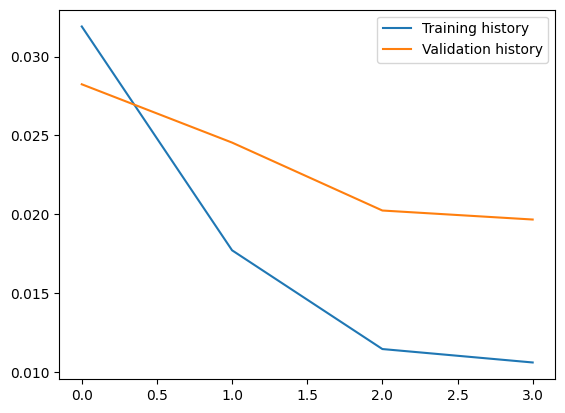

In [83]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

# Trial


In [84]:
model = fitter.model

In [85]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [100.5526123046875, 95.9157485961914, 120.07015228271484, 133.46563720703125]


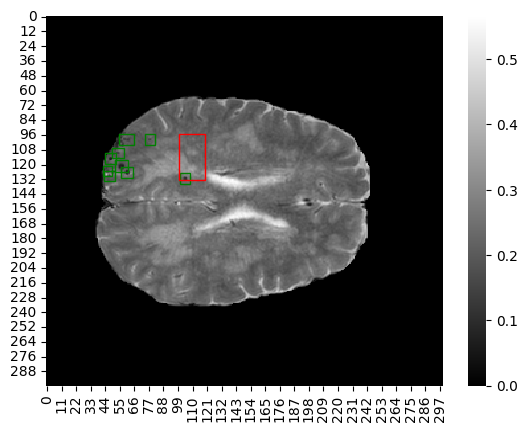

pr_bbox bbox [98.78807067871094, 120.84083557128906, 86.3652114868164, 151.7504119873047]


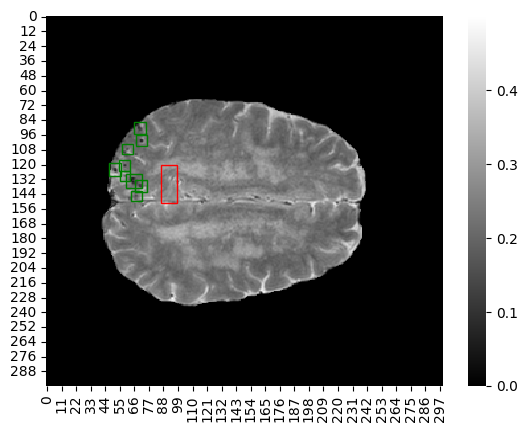

pr_bbox bbox [113.458740234375, 105.44439697265625, 133.50311279296875, 151.3252410888672]


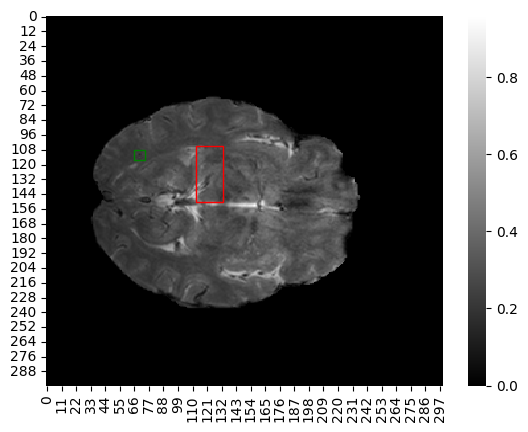

pr_bbox bbox [73.35514068603516, 109.3233413696289, 77.31961822509766, 109.60369873046875]


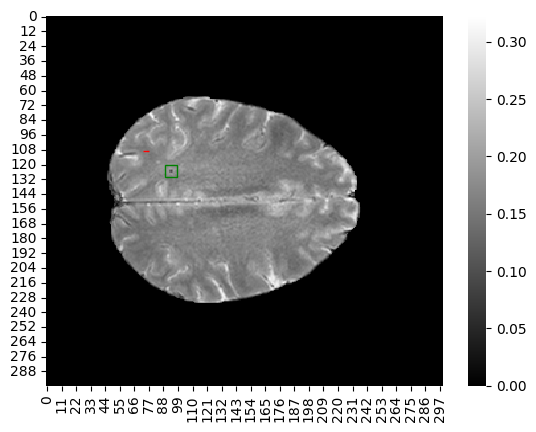

pr_bbox bbox [127.402099609375, 112.48776245117188, 76.54476165771484, 137.49285888671875]


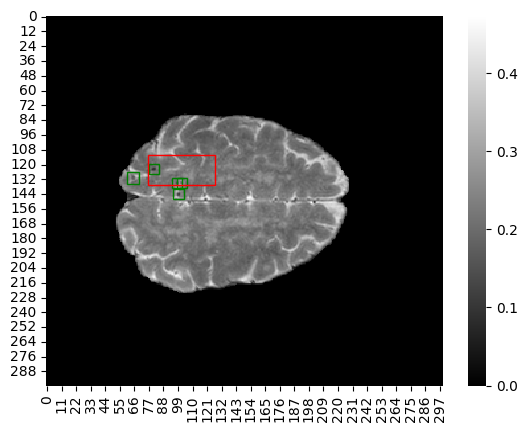

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [94.50566101074219, 95.24647521972656, 77.21861267089844, 142.22422790527344]


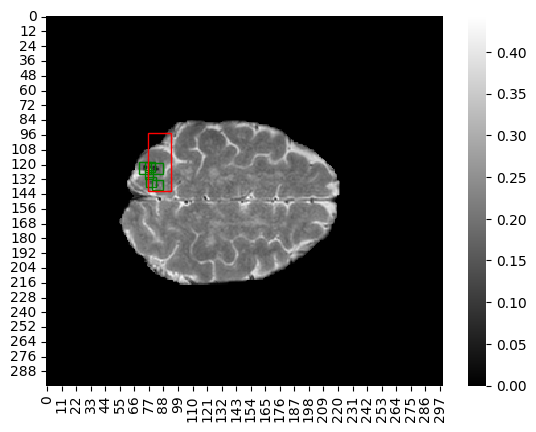

pr_bbox bbox [116.4697494506836, 177.02011108398438, 143.07757568359375, 210.8046417236328]


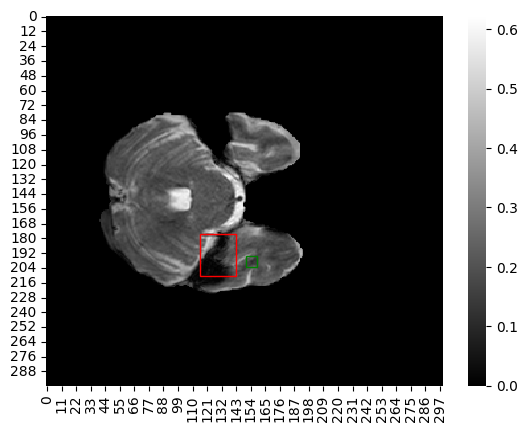

pr_bbox bbox [91.76824188232422, 149.98448181152344, 117.89442443847656, 182.02928161621094]


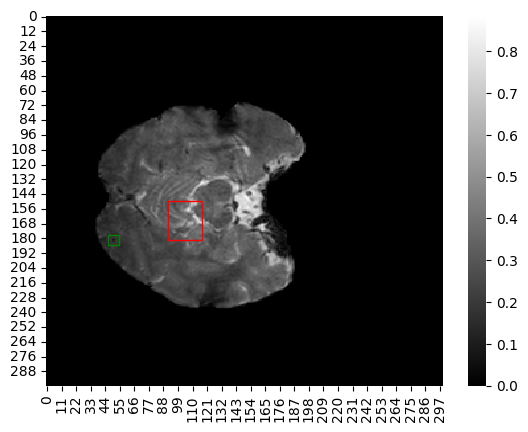

pr_bbox bbox [102.8370132446289, 139.18951416015625, 71.83475494384766, 134.00506591796875]


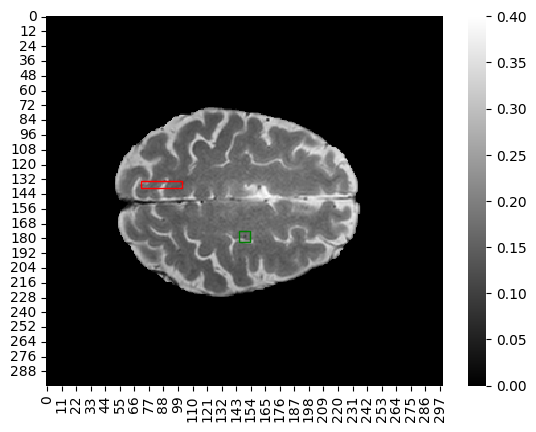

In [86]:
for index, batch in enumerate(vl):
    # for i in range(len(batch)):
        images, masks, targets, cases = batch
        
        for slices, masks, target, case in zip(images, masks, targets, cases):
            slices = torch.stack(slices[0]).squeeze(1).float().repeat(1, 3, 1, 1).to(device)
            masks = masks[0]
            
            y = model(slices, target)
            gt_bboxes = masks[target].cpu().numpy()
            pr_bboxes = [(y * 300).squeeze().detach().cpu().tolist()]
            
            fig, ax = plt.subplots()
            ax = sns.heatmap(slices[target][0].squeeze().cpu(), cmap='gray')
            
            for gt_bbox in gt_bboxes[0]: 
                truth = patches.Rectangle(
                    (gt_bbox[0], gt_bbox[1]), 
                    gt_bbox[2] - gt_bbox[0],  
                    gt_bbox[3] - gt_bbox[1], 
                    linewidth=1, edgecolor='g', facecolor='none'
                )
                ax.add_patch(truth)

            for pr_bbox in pr_bboxes:
                print('pr_bbox bbox', pr_bbox)
                pred = patches.Rectangle(
                    (pr_bbox[0], pr_bbox[1]),
                    pr_bbox[2] - pr_bbox[0],
                    pr_bbox[3] - pr_bbox[1],
                    linewidth=1, edgecolor='r', facecolor='none'
                )
                ax.add_patch(pred)
                
            plt.show()
        
    